In [1]:
%pylab inline
import logging
logger = logging.getLogger()
logger.setLevel(logging.ERROR)
from IPython.display import clear_output
import time
#from time import sleep
import numpy as np
import pandas as pd
from sklearn import linear_model
import math
import gym
import myfrozen
import pickle
import img_utils
import os
from gym.envs.registration import register

Populating the interactive namespace from numpy and matplotlib


In [2]:
from __future__ import print_function, division

from keras.layers import Input, Dense, Reshape, Flatten, Dropout
from keras.layers import BatchNormalization, Activation, Lambda
from keras.layers.advanced_activations import LeakyReLU, Softmax
from keras.layers.convolutional import UpSampling2D, Conv2D
from keras.models import Sequential, Model
from keras.optimizers import Adam
from keras.utils.np_utils import to_categorical
from keras import backend as K

import matplotlib.pyplot as plt

import sys
from copy import deepcopy
import h5py

Using TensorFlow backend.


In [6]:
def get_data(dictionary):
    models = []
    i = 0
    for k, v in dictionary.items():
        for kp, vp in v.items():
            if kp == 'model':
                models.append(vp)
    models = np.array([models[i].coef_ for i in xrange(len(models)) if len(models[i].coef_)==125])
    return models

def load_all_data(foldername):
    all_data = np.empty((0,125))
    for filename in os.listdir(foldername):
        if filename.endswith((".pkl")):
            x = os.path.join(foldername,filename)
            full = pickle.load(open(x,'rb'))
            X_temp = get_data(full)
            all_data = np.concatenate((all_data, X_temp))
    np.random.seed(123)
    np.random.shuffle(all_data)
    return all_data

In [7]:
X_train = load_all_data('saved')

/anaconda/envs/drl/lib/python2.7/site-packages/sklearn/base.py:311: UserWarning: Trying to unpickle estimator LinearRegression from version 0.19.0 when using version 0.19.1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


In [8]:
X_train.shape

(725, 125)

In [9]:
class GAN():
    def __init__(self):
        self.img_rows = 125
        self.img_cols = 1
        self.channels = 1
        self.img_shape = (self.img_rows, self.img_cols, self.channels)
        self.latent_dim = 64

        optimizer = Adam(0.0001, 0.5)

        # Build and compile the discriminator
        self.discriminator = self.build_discriminator()
        self.discriminator.compile(loss='binary_crossentropy',
            optimizer=optimizer,
            metrics=['accuracy'])

        # Build the generator
        self.generator = self.build_generator()

        # The generator takes noise as input and generates imgs
        z = Input(shape=(self.latent_dim,))
        img = self.generator(z)

        # For the combined model we will only train the generator
        self.discriminator.trainable = False

        # The discriminator takes generated images as input and determines validity
        validity = self.discriminator(img)

        # The combined model  (stacked generator and discriminator)
        # Trains the generator to fool the discriminator
        self.combined = Model(z, validity)
        self.combined.compile(loss='binary_crossentropy', optimizer=optimizer)
        
    def build_generator(self):

        model = Sequential()

        model.add(Dense(256, input_dim=self.latent_dim))
        model.add(LeakyReLU(alpha=0.2))
        model.add(BatchNormalization(momentum=0.8))
        model.add(Dense(512))
        model.add(LeakyReLU(alpha=0.2))
        model.add(BatchNormalization(momentum=0.8))
        model.add(Dense(1024))
        model.add(LeakyReLU(alpha=0.2))
        model.add(BatchNormalization(momentum=0.8))
        model.add(Dense(np.prod(self.img_shape), activation='sigmoid'))
        model.add(Reshape(self.img_shape))

        model.summary()

        noise = Input(shape=(self.latent_dim,))
        img = model(noise)

        return Model(noise, img)
    
    def build_discriminator(self):

        model = Sequential()

        model.add(Flatten(input_shape=self.img_shape))
        #model.add(Dense(512))
        #model.add(LeakyReLU(alpha=0.2))
        model.add(Dense(256))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dense(1, activation='sigmoid'))
        model.summary()

        img = Input(shape=self.img_shape)
        validity = model(img)

        return Model(img, validity)
    
    def train(self, epochs, batch_size=128, sample_interval=50):
        
        D = {}
        #X_train = mix_data()
        X_train = load_all_data('saved')
        X_train = np.expand_dims(X_train, axis=3)
        X_train = np.expand_dims(X_train, axis=4)

        # Adversarial ground truths
        valid = np.ones((batch_size, 1))
        fake = np.zeros((batch_size, 1))

        for epoch in range(epochs):

            # ---------------------
            #  Train Discriminator
            # ---------------------

            # Select a random batch of images
            idx = np.random.randint(0, X_train.shape[0], batch_size)
            imgs = X_train[idx]

            noise = np.random.normal(0, 1, (batch_size, self.latent_dim))

            # Generate a batch of new images
            gen_imgs = self.generator.predict(noise)

            # Train the discriminator 
            d_loss_real = self.discriminator.train_on_batch(imgs, valid)
            d_loss_fake = self.discriminator.train_on_batch(gen_imgs, fake)
            d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

            # ---------------------
            #  Train Generator
            # ---------------------

            noise = np.random.normal(0, 1, (batch_size, self.latent_dim))

            # Train the generator (to have the discriminator label samples as valid)
            g_loss = self.combined.train_on_batch(noise, valid)

            # Plot the progress
            print ("%d [D loss: %f, acc.: %.2f%%] [G loss: %f]" % (epoch, d_loss[0], 100*d_loss[1], g_loss))

            # If at save interval => save generated image samples
            if epoch % sample_interval == 0:
                D = self.sample_images(epoch,D)
                
        self.generator.save('models/rewards/generator.h5')
        self.discriminator.save('models/rewards/discriminator.h5')
        return D
    
    def sample_images(self, epoch,D):
        
        OBSERVATION_SPACE = 64
        ACTION_SPACE = 4
        
        def to_onehot(size,value):
          my_onehot = np.zeros((size))
          my_onehot[value] = 1.0
          return my_onehot
    
        def heatmap2d(hm_mat, title='', fig_num=1, text=True):
            plt.figure(fig_num)
            plt.imshow(hm_mat, interpolation='nearest')
            plt.title(title)
            plt.colorbar()
            
            if text:
                for y in range(hm_mat.shape[0]):
                  for x in range(hm_mat.shape[1]):
                    plt.text(x, y, '%.1f' % hm_mat[y, x],
                     horizontalalignment='center',
                     verticalalignment='center',
                     )
                    
            plt.savefig("rewardsamples/%d.png" % fig_num, format='png')
            
        def compute_reward(s,new_s,a,gen_imgs):
            zerostates = {12, 21, 29, 37, 44, 52, 58}
            s = to_onehot(OBSERVATION_SPACE,s)
            new_s = to_onehot(OBSERVATION_SPACE,new_s)
            a = to_onehot(ACTION_SPACE,a)
            vectorized = np.hstack((s,new_s,a))
            index = list(zerostates)
            vectorized = np.delete(vectorized, index)
            return np.dot(gen_imgs,vectorized)

        def fill_rewards(gen_imgs):
            tofill = np.zeros((OBSERVATION_SPACE,OBSERVATION_SPACE,ACTION_SPACE)) 
            for s in xrange(0,OBSERVATION_SPACE):
                for new_s in xrange(0,OBSERVATION_SPACE):
                    for a in xrange(0,ACTION_SPACE):
                        tofill[(s,new_s,a)] = compute_reward(s,new_s,a,gen_imgs)
            sub = tofill[0, :, :]
            sub = np.max(sub,axis=1)
            return sub
        
        #r, c = 1, 1
        for iteration in range(5):
            noise = np.random.normal(0, 1, (1, self.latent_dim))
            gen_imgs = self.generator.predict(noise)
            gen_imgs = np.squeeze(gen_imgs, axis=0)
            gen_imgs = np.squeeze(gen_imgs, axis=2)
            gen_imgs = np.squeeze(gen_imgs, axis=1)
        
            hm_mat = fill_rewards(gen_imgs)
            hm_mat = np.expand_dims(hm_mat,axis=1)
            
            heatmap2d(np.reshape(hm_mat, (8, 8)), title='', fig_num=int(str(epoch) + str(iteration)), text=True)
        
            D[str(epoch)] = {}
            D[str(epoch)][str(iteration)] = gen_imgs
            #D[str(epoch)][str(iteration)]["coeff"] = gen_imgs
            
        return D

In [10]:
gan = GAN()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_1 (Flatten)          (None, 125)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 256)               32256     
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 256)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 257       
Total params: 32,513
Trainable params: 32,513
Non-trainable params: 0
_________________________________________________________________
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_3 (Dense)              (None, 256)               16640     
_________________________________________________________________
leaky_

/anaconda/envs/drl/lib/python2.7/site-packages/sklearn/base.py:311: UserWarning: Trying to unpickle estimator LinearRegression from version 0.19.0 when using version 0.19.1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
/anaconda/envs/drl/lib/python2.7/site-packages/ipykernel/__main__.py:80: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/anaconda/envs/drl/lib/python2.7/site-packages/ipykernel/__main__.py:81: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/anaconda/envs/drl/lib/python2.7/site-packages/keras/engine/training.py:478: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


0 [D loss: 0.625868, acc.: 91.67%] [G loss: 0.830784]
1 [D loss: 0.624168, acc.: 76.67%] [G loss: 0.901827]
2 [D loss: 0.588801, acc.: 83.33%] [G loss: 0.970821]
3 [D loss: 0.573421, acc.: 90.00%] [G loss: 1.049160]
4 [D loss: 0.565028, acc.: 81.67%] [G loss: 1.124665]
5 [D loss: 0.538483, acc.: 76.67%] [G loss: 1.209482]
6 [D loss: 0.528370, acc.: 83.33%] [G loss: 1.277579]
7 [D loss: 0.502208, acc.: 85.00%] [G loss: 1.366826]
8 [D loss: 0.492949, acc.: 83.33%] [G loss: 1.432670]
9 [D loss: 0.474130, acc.: 83.33%] [G loss: 1.513895]
10 [D loss: 0.463123, acc.: 78.33%] [G loss: 1.552955]
11 [D loss: 0.464066, acc.: 81.67%] [G loss: 1.621571]
12 [D loss: 0.443381, acc.: 88.33%] [G loss: 1.694839]
13 [D loss: 0.441067, acc.: 85.00%] [G loss: 1.746592]
14 [D loss: 0.437713, acc.: 81.67%] [G loss: 1.790586]
15 [D loss: 0.421157, acc.: 91.67%] [G loss: 1.885616]
16 [D loss: 0.419131, acc.: 88.33%] [G loss: 1.905909]
17 [D loss: 0.435859, acc.: 76.67%] [G loss: 1.976522]
18 [D loss: 0.420467

153 [D loss: 0.278677, acc.: 100.00%] [G loss: 4.106417]
154 [D loss: 0.294046, acc.: 95.00%] [G loss: 4.066865]
155 [D loss: 0.277231, acc.: 98.33%] [G loss: 4.043753]
156 [D loss: 0.267580, acc.: 98.33%] [G loss: 4.146381]
157 [D loss: 0.274334, acc.: 96.67%] [G loss: 4.336762]
158 [D loss: 0.282667, acc.: 98.33%] [G loss: 4.306985]
159 [D loss: 0.279505, acc.: 98.33%] [G loss: 4.326601]
160 [D loss: 0.278693, acc.: 98.33%] [G loss: 4.205902]
161 [D loss: 0.273779, acc.: 100.00%] [G loss: 4.405065]
162 [D loss: 0.275334, acc.: 98.33%] [G loss: 4.286344]
163 [D loss: 0.272321, acc.: 100.00%] [G loss: 4.285336]
164 [D loss: 0.317205, acc.: 93.33%] [G loss: 4.363586]
165 [D loss: 0.286715, acc.: 100.00%] [G loss: 4.315041]
166 [D loss: 0.264867, acc.: 98.33%] [G loss: 4.365436]
167 [D loss: 0.288597, acc.: 100.00%] [G loss: 4.619107]
168 [D loss: 0.287614, acc.: 100.00%] [G loss: 4.611954]
169 [D loss: 0.279584, acc.: 95.00%] [G loss: 4.414323]
170 [D loss: 0.275357, acc.: 98.33%] [G lo

300 [D loss: 0.295715, acc.: 95.00%] [G loss: 5.858160]
301 [D loss: 0.272705, acc.: 95.00%] [G loss: 5.467949]
302 [D loss: 0.299630, acc.: 93.33%] [G loss: 5.989473]
303 [D loss: 0.302021, acc.: 91.67%] [G loss: 5.905255]
304 [D loss: 0.311430, acc.: 90.00%] [G loss: 5.101858]
305 [D loss: 0.326809, acc.: 88.33%] [G loss: 5.373725]
306 [D loss: 0.291506, acc.: 95.00%] [G loss: 6.084649]
307 [D loss: 0.332140, acc.: 85.00%] [G loss: 6.517635]
308 [D loss: 0.312114, acc.: 88.33%] [G loss: 6.549121]
309 [D loss: 0.323275, acc.: 90.00%] [G loss: 6.522145]
310 [D loss: 0.319955, acc.: 88.33%] [G loss: 5.741628]
311 [D loss: 0.318980, acc.: 91.67%] [G loss: 6.334399]
312 [D loss: 0.319898, acc.: 90.00%] [G loss: 6.186667]
313 [D loss: 0.310856, acc.: 86.67%] [G loss: 6.087600]
314 [D loss: 0.312157, acc.: 91.67%] [G loss: 5.370574]
315 [D loss: 0.327285, acc.: 86.67%] [G loss: 5.832743]
316 [D loss: 0.348770, acc.: 90.00%] [G loss: 6.832964]
317 [D loss: 0.312242, acc.: 86.67%] [G loss: 5.

447 [D loss: 0.527722, acc.: 66.67%] [G loss: 4.916733]
448 [D loss: 0.527572, acc.: 63.33%] [G loss: 4.278565]
449 [D loss: 0.537639, acc.: 63.33%] [G loss: 3.471745]
450 [D loss: 0.485114, acc.: 68.33%] [G loss: 3.753966]
451 [D loss: 0.531917, acc.: 63.33%] [G loss: 2.587240]
452 [D loss: 0.463750, acc.: 73.33%] [G loss: 4.175043]
453 [D loss: 0.486033, acc.: 70.00%] [G loss: 3.426297]
454 [D loss: 0.475495, acc.: 71.67%] [G loss: 2.837489]
455 [D loss: 0.462649, acc.: 73.33%] [G loss: 3.971056]
456 [D loss: 0.465314, acc.: 76.67%] [G loss: 3.563541]
457 [D loss: 0.541343, acc.: 66.67%] [G loss: 3.311955]
458 [D loss: 0.557852, acc.: 63.33%] [G loss: 4.342988]
459 [D loss: 0.458854, acc.: 76.67%] [G loss: 2.419485]
460 [D loss: 0.421486, acc.: 80.00%] [G loss: 3.472290]
461 [D loss: 0.532523, acc.: 66.67%] [G loss: 4.469197]
462 [D loss: 0.524393, acc.: 68.33%] [G loss: 4.074327]
463 [D loss: 0.531765, acc.: 70.00%] [G loss: 4.437585]
464 [D loss: 0.475877, acc.: 75.00%] [G loss: 3.

597 [D loss: 0.578460, acc.: 71.67%] [G loss: 4.764391]
598 [D loss: 0.523427, acc.: 63.33%] [G loss: 3.726274]
599 [D loss: 0.597179, acc.: 51.67%] [G loss: 3.230999]
600 [D loss: 0.478369, acc.: 76.67%] [G loss: 2.877137]
601 [D loss: 0.526070, acc.: 71.67%] [G loss: 2.750170]
602 [D loss: 0.565927, acc.: 65.00%] [G loss: 3.197662]
603 [D loss: 0.521413, acc.: 66.67%] [G loss: 2.417301]
604 [D loss: 0.437748, acc.: 78.33%] [G loss: 3.174047]
605 [D loss: 0.471483, acc.: 71.67%] [G loss: 3.118221]
606 [D loss: 0.469374, acc.: 73.33%] [G loss: 2.283592]
607 [D loss: 0.471628, acc.: 71.67%] [G loss: 2.308131]
608 [D loss: 0.534561, acc.: 63.33%] [G loss: 3.179600]
609 [D loss: 0.503838, acc.: 71.67%] [G loss: 4.517395]
610 [D loss: 0.477016, acc.: 66.67%] [G loss: 2.888736]
611 [D loss: 0.539361, acc.: 70.00%] [G loss: 3.191284]
612 [D loss: 0.536419, acc.: 68.33%] [G loss: 2.743825]
613 [D loss: 0.521694, acc.: 70.00%] [G loss: 3.696511]
614 [D loss: 0.564244, acc.: 63.33%] [G loss: 4.

746 [D loss: 0.525772, acc.: 70.00%] [G loss: 2.926599]
747 [D loss: 0.536988, acc.: 71.67%] [G loss: 2.718506]
748 [D loss: 0.541483, acc.: 63.33%] [G loss: 3.198553]
749 [D loss: 0.528519, acc.: 65.00%] [G loss: 2.764871]
750 [D loss: 0.517623, acc.: 66.67%] [G loss: 3.613213]
751 [D loss: 0.536872, acc.: 66.67%] [G loss: 2.210584]
752 [D loss: 0.496114, acc.: 78.33%] [G loss: 2.864213]
753 [D loss: 0.481463, acc.: 73.33%] [G loss: 3.292694]
754 [D loss: 0.522190, acc.: 70.00%] [G loss: 2.254580]
755 [D loss: 0.553983, acc.: 63.33%] [G loss: 2.679944]
756 [D loss: 0.484540, acc.: 70.00%] [G loss: 2.261220]
757 [D loss: 0.510454, acc.: 76.67%] [G loss: 2.136438]
758 [D loss: 0.491599, acc.: 68.33%] [G loss: 2.670697]
759 [D loss: 0.566098, acc.: 65.00%] [G loss: 2.247170]
760 [D loss: 0.513985, acc.: 81.67%] [G loss: 2.274609]
761 [D loss: 0.537956, acc.: 70.00%] [G loss: 2.694605]
762 [D loss: 0.552115, acc.: 63.33%] [G loss: 2.300332]
763 [D loss: 0.527352, acc.: 68.33%] [G loss: 2.

896 [D loss: 0.572181, acc.: 63.33%] [G loss: 2.470623]
897 [D loss: 0.547479, acc.: 63.33%] [G loss: 1.879460]
898 [D loss: 0.476532, acc.: 78.33%] [G loss: 3.721245]
899 [D loss: 0.471198, acc.: 71.67%] [G loss: 1.845866]
900 [D loss: 0.504569, acc.: 73.33%] [G loss: 2.264435]
901 [D loss: 0.518093, acc.: 70.00%] [G loss: 1.915203]
902 [D loss: 0.460574, acc.: 76.67%] [G loss: 2.259451]
903 [D loss: 0.624756, acc.: 65.00%] [G loss: 3.249321]
904 [D loss: 0.563800, acc.: 71.67%] [G loss: 2.545969]
905 [D loss: 0.491653, acc.: 76.67%] [G loss: 2.264031]
906 [D loss: 0.527258, acc.: 71.67%] [G loss: 2.726531]
907 [D loss: 0.528493, acc.: 70.00%] [G loss: 2.995153]
908 [D loss: 0.510681, acc.: 68.33%] [G loss: 2.919255]
909 [D loss: 0.460710, acc.: 81.67%] [G loss: 2.774314]
910 [D loss: 0.483177, acc.: 80.00%] [G loss: 2.762601]
911 [D loss: 0.517857, acc.: 68.33%] [G loss: 1.984608]
912 [D loss: 0.550604, acc.: 66.67%] [G loss: 3.278472]
913 [D loss: 0.446785, acc.: 75.00%] [G loss: 3.

1042 [D loss: 0.537473, acc.: 76.67%] [G loss: 2.736314]
1043 [D loss: 0.479140, acc.: 80.00%] [G loss: 2.754541]
1044 [D loss: 0.444622, acc.: 85.00%] [G loss: 2.812937]
1045 [D loss: 0.482316, acc.: 73.33%] [G loss: 2.353756]
1046 [D loss: 0.540643, acc.: 70.00%] [G loss: 3.358695]
1047 [D loss: 0.563933, acc.: 63.33%] [G loss: 2.291220]
1048 [D loss: 0.496455, acc.: 70.00%] [G loss: 2.702050]
1049 [D loss: 0.579214, acc.: 58.33%] [G loss: 1.883819]
1050 [D loss: 0.521386, acc.: 68.33%] [G loss: 1.813632]
1051 [D loss: 0.492320, acc.: 70.00%] [G loss: 2.948823]
1052 [D loss: 0.485468, acc.: 81.67%] [G loss: 1.610186]
1053 [D loss: 0.477900, acc.: 80.00%] [G loss: 1.843098]
1054 [D loss: 0.499790, acc.: 76.67%] [G loss: 2.293118]
1055 [D loss: 0.540139, acc.: 78.33%] [G loss: 2.744840]
1056 [D loss: 0.539533, acc.: 66.67%] [G loss: 2.257567]
1057 [D loss: 0.490577, acc.: 81.67%] [G loss: 1.561935]
1058 [D loss: 0.592734, acc.: 61.67%] [G loss: 1.777034]
1059 [D loss: 0.481659, acc.: 7

1186 [D loss: 0.511894, acc.: 81.67%] [G loss: 1.891246]
1187 [D loss: 0.539288, acc.: 73.33%] [G loss: 1.824666]
1188 [D loss: 0.511702, acc.: 75.00%] [G loss: 1.574031]
1189 [D loss: 0.611117, acc.: 68.33%] [G loss: 2.782003]
1190 [D loss: 0.573435, acc.: 70.00%] [G loss: 1.467116]
1191 [D loss: 0.512969, acc.: 80.00%] [G loss: 2.277357]
1192 [D loss: 0.537331, acc.: 78.33%] [G loss: 2.265806]
1193 [D loss: 0.536641, acc.: 75.00%] [G loss: 2.069074]
1194 [D loss: 0.557518, acc.: 68.33%] [G loss: 2.271030]
1195 [D loss: 0.521220, acc.: 73.33%] [G loss: 2.109180]
1196 [D loss: 0.536931, acc.: 70.00%] [G loss: 2.421984]
1197 [D loss: 0.611501, acc.: 55.00%] [G loss: 2.292870]
1198 [D loss: 0.622113, acc.: 63.33%] [G loss: 1.878564]
1199 [D loss: 0.527976, acc.: 78.33%] [G loss: 1.841911]
1200 [D loss: 0.519000, acc.: 76.67%] [G loss: 2.283442]
1201 [D loss: 0.599245, acc.: 68.33%] [G loss: 2.831570]
1202 [D loss: 0.555455, acc.: 76.67%] [G loss: 2.519777]
1203 [D loss: 0.512891, acc.: 7

1333 [D loss: 0.526373, acc.: 75.00%] [G loss: 1.941329]
1334 [D loss: 0.494404, acc.: 80.00%] [G loss: 1.899786]
1335 [D loss: 0.531341, acc.: 76.67%] [G loss: 1.556299]
1336 [D loss: 0.531875, acc.: 80.00%] [G loss: 1.412590]
1337 [D loss: 0.581155, acc.: 75.00%] [G loss: 1.878423]
1338 [D loss: 0.466165, acc.: 76.67%] [G loss: 1.849281]
1339 [D loss: 0.482204, acc.: 81.67%] [G loss: 1.887118]
1340 [D loss: 0.520702, acc.: 80.00%] [G loss: 1.413172]
1341 [D loss: 0.505352, acc.: 81.67%] [G loss: 1.853690]
1342 [D loss: 0.480162, acc.: 86.67%] [G loss: 1.840044]
1343 [D loss: 0.555130, acc.: 78.33%] [G loss: 1.860617]
1344 [D loss: 0.498517, acc.: 86.67%] [G loss: 2.437181]
1345 [D loss: 0.464111, acc.: 85.00%] [G loss: 1.988416]
1346 [D loss: 0.477137, acc.: 85.00%] [G loss: 1.993194]
1347 [D loss: 0.567815, acc.: 75.00%] [G loss: 2.172466]
1348 [D loss: 0.522310, acc.: 81.67%] [G loss: 1.541504]
1349 [D loss: 0.501542, acc.: 88.33%] [G loss: 2.614959]
1350 [D loss: 0.420846, acc.: 8

1481 [D loss: 0.529683, acc.: 88.33%] [G loss: 0.861474]
1482 [D loss: 0.467546, acc.: 93.33%] [G loss: 0.875827]
1483 [D loss: 0.530025, acc.: 86.67%] [G loss: 0.820736]
1484 [D loss: 0.528868, acc.: 85.00%] [G loss: 1.368860]
1485 [D loss: 0.594095, acc.: 86.67%] [G loss: 0.864959]
1486 [D loss: 0.569166, acc.: 83.33%] [G loss: 0.869853]
1487 [D loss: 0.505262, acc.: 85.00%] [G loss: 0.854860]
1488 [D loss: 0.520296, acc.: 90.00%] [G loss: 0.892466]
1489 [D loss: 0.530620, acc.: 81.67%] [G loss: 0.837842]
1490 [D loss: 0.528663, acc.: 90.00%] [G loss: 0.993531]
1491 [D loss: 0.524775, acc.: 86.67%] [G loss: 0.830109]
1492 [D loss: 0.517429, acc.: 93.33%] [G loss: 0.867149]
1493 [D loss: 0.512045, acc.: 95.00%] [G loss: 0.879668]
1494 [D loss: 0.498455, acc.: 85.00%] [G loss: 0.902625]
1495 [D loss: 0.518133, acc.: 88.33%] [G loss: 0.823509]
1496 [D loss: 0.550511, acc.: 83.33%] [G loss: 0.909977]
1497 [D loss: 0.510831, acc.: 86.67%] [G loss: 1.153162]
1498 [D loss: 0.541428, acc.: 8

1625 [D loss: 0.496405, acc.: 91.67%] [G loss: 0.824829]
1626 [D loss: 0.532470, acc.: 90.00%] [G loss: 0.805471]
1627 [D loss: 0.562507, acc.: 90.00%] [G loss: 0.809172]
1628 [D loss: 0.532375, acc.: 86.67%] [G loss: 0.821054]
1629 [D loss: 0.474532, acc.: 91.67%] [G loss: 0.980724]
1630 [D loss: 0.570563, acc.: 81.67%] [G loss: 0.789267]
1631 [D loss: 0.502105, acc.: 86.67%] [G loss: 0.785850]
1632 [D loss: 0.581099, acc.: 85.00%] [G loss: 0.781514]
1633 [D loss: 0.560748, acc.: 88.33%] [G loss: 0.787210]
1634 [D loss: 0.520688, acc.: 91.67%] [G loss: 0.787708]
1635 [D loss: 0.594705, acc.: 88.33%] [G loss: 0.786503]
1636 [D loss: 0.594193, acc.: 85.00%] [G loss: 0.786876]
1637 [D loss: 0.481602, acc.: 95.00%] [G loss: 0.791925]
1638 [D loss: 0.565125, acc.: 90.00%] [G loss: 0.786872]
1639 [D loss: 0.549298, acc.: 95.00%] [G loss: 0.788991]
1640 [D loss: 0.527103, acc.: 90.00%] [G loss: 0.786983]
1641 [D loss: 0.559622, acc.: 83.33%] [G loss: 0.780062]
1642 [D loss: 0.521082, acc.: 9

1769 [D loss: 0.563942, acc.: 78.33%] [G loss: 0.890001]
1770 [D loss: 0.520535, acc.: 83.33%] [G loss: 0.868119]
1771 [D loss: 0.540580, acc.: 80.00%] [G loss: 0.892317]
1772 [D loss: 0.533051, acc.: 88.33%] [G loss: 0.877336]
1773 [D loss: 0.637539, acc.: 75.00%] [G loss: 0.891210]
1774 [D loss: 0.592340, acc.: 73.33%] [G loss: 0.896242]
1775 [D loss: 0.572436, acc.: 75.00%] [G loss: 0.909397]
1776 [D loss: 0.572010, acc.: 71.67%] [G loss: 0.906778]
1777 [D loss: 0.525035, acc.: 83.33%] [G loss: 0.926013]
1778 [D loss: 0.524240, acc.: 83.33%] [G loss: 0.940078]
1779 [D loss: 0.514356, acc.: 83.33%] [G loss: 0.871795]
1780 [D loss: 0.554650, acc.: 75.00%] [G loss: 0.888260]
1781 [D loss: 0.606971, acc.: 71.67%] [G loss: 0.904578]
1782 [D loss: 0.551488, acc.: 78.33%] [G loss: 0.934244]
1783 [D loss: 0.529909, acc.: 75.00%] [G loss: 0.905022]
1784 [D loss: 0.547035, acc.: 68.33%] [G loss: 0.913504]
1785 [D loss: 0.579169, acc.: 70.00%] [G loss: 0.923428]
1786 [D loss: 0.510873, acc.: 7

1919 [D loss: 0.546453, acc.: 91.67%] [G loss: 0.856188]
1920 [D loss: 0.563052, acc.: 90.00%] [G loss: 0.887567]
1921 [D loss: 0.543723, acc.: 90.00%] [G loss: 0.895064]
1922 [D loss: 0.528099, acc.: 86.67%] [G loss: 0.877105]
1923 [D loss: 0.469685, acc.: 90.00%] [G loss: 0.876064]
1924 [D loss: 0.567824, acc.: 83.33%] [G loss: 1.014349]
1925 [D loss: 0.558891, acc.: 86.67%] [G loss: 0.907833]
1926 [D loss: 0.560359, acc.: 88.33%] [G loss: 0.876913]
1927 [D loss: 0.549399, acc.: 86.67%] [G loss: 0.901430]
1928 [D loss: 0.544284, acc.: 86.67%] [G loss: 0.917181]
1929 [D loss: 0.524781, acc.: 90.00%] [G loss: 0.880362]
1930 [D loss: 0.553322, acc.: 83.33%] [G loss: 0.937636]
1931 [D loss: 0.549140, acc.: 86.67%] [G loss: 0.932839]
1932 [D loss: 0.565662, acc.: 83.33%] [G loss: 0.951975]
1933 [D loss: 0.596521, acc.: 81.67%] [G loss: 0.960439]
1934 [D loss: 0.575339, acc.: 80.00%] [G loss: 0.966194]
1935 [D loss: 0.463830, acc.: 95.00%] [G loss: 0.944044]
1936 [D loss: 0.590390, acc.: 8

/anaconda/envs/drl/lib/python2.7/site-packages/matplotlib/pyplot.py:537: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


2001 [D loss: 0.550306, acc.: 86.67%] [G loss: 0.955408]
2002 [D loss: 0.478921, acc.: 93.33%] [G loss: 0.976315]
2003 [D loss: 0.550736, acc.: 83.33%] [G loss: 1.008492]
2004 [D loss: 0.549766, acc.: 86.67%] [G loss: 0.974850]
2005 [D loss: 0.585283, acc.: 81.67%] [G loss: 0.964872]
2006 [D loss: 0.504077, acc.: 83.33%] [G loss: 1.007477]
2007 [D loss: 0.521670, acc.: 80.00%] [G loss: 0.955155]
2008 [D loss: 0.467451, acc.: 90.00%] [G loss: 0.952792]
2009 [D loss: 0.519821, acc.: 83.33%] [G loss: 0.941742]
2010 [D loss: 0.567868, acc.: 86.67%] [G loss: 0.965302]
2011 [D loss: 0.581011, acc.: 83.33%] [G loss: 0.926384]
2012 [D loss: 0.610692, acc.: 78.33%] [G loss: 0.927364]
2013 [D loss: 0.520201, acc.: 85.00%] [G loss: 0.935639]
2014 [D loss: 0.554573, acc.: 86.67%] [G loss: 0.957797]
2015 [D loss: 0.470716, acc.: 91.67%] [G loss: 0.981548]
2016 [D loss: 0.487789, acc.: 86.67%] [G loss: 0.973351]
2017 [D loss: 0.488290, acc.: 90.00%] [G loss: 0.946586]
2018 [D loss: 0.505701, acc.: 8

2146 [D loss: 0.509262, acc.: 78.33%] [G loss: 0.977811]
2147 [D loss: 0.550487, acc.: 76.67%] [G loss: 0.943809]
2148 [D loss: 0.533205, acc.: 81.67%] [G loss: 0.968894]
2149 [D loss: 0.542082, acc.: 83.33%] [G loss: 0.957947]
2150 [D loss: 0.501031, acc.: 85.00%] [G loss: 0.958515]
2151 [D loss: 0.504855, acc.: 88.33%] [G loss: 0.945118]
2152 [D loss: 0.499320, acc.: 86.67%] [G loss: 0.995839]
2153 [D loss: 0.494468, acc.: 90.00%] [G loss: 0.980855]
2154 [D loss: 0.546796, acc.: 75.00%] [G loss: 0.982277]
2155 [D loss: 0.523535, acc.: 86.67%] [G loss: 0.971731]
2156 [D loss: 0.539499, acc.: 86.67%] [G loss: 0.940556]
2157 [D loss: 0.589218, acc.: 76.67%] [G loss: 0.940711]
2158 [D loss: 0.485875, acc.: 88.33%] [G loss: 0.927407]
2159 [D loss: 0.487742, acc.: 83.33%] [G loss: 0.931512]
2160 [D loss: 0.541919, acc.: 76.67%] [G loss: 0.917766]
2161 [D loss: 0.530374, acc.: 85.00%] [G loss: 0.929217]
2162 [D loss: 0.549803, acc.: 83.33%] [G loss: 0.940892]
2163 [D loss: 0.533401, acc.: 7

2293 [D loss: 0.486824, acc.: 86.67%] [G loss: 1.026065]
2294 [D loss: 0.442689, acc.: 93.33%] [G loss: 1.095526]
2295 [D loss: 0.463162, acc.: 83.33%] [G loss: 1.120497]
2296 [D loss: 0.526166, acc.: 78.33%] [G loss: 1.098041]
2297 [D loss: 0.480398, acc.: 85.00%] [G loss: 1.104067]
2298 [D loss: 0.448537, acc.: 88.33%] [G loss: 1.030493]
2299 [D loss: 0.508348, acc.: 86.67%] [G loss: 1.096703]
2300 [D loss: 0.447426, acc.: 88.33%] [G loss: 1.061551]
2301 [D loss: 0.493183, acc.: 95.00%] [G loss: 1.057579]
2302 [D loss: 0.470462, acc.: 85.00%] [G loss: 1.005396]
2303 [D loss: 0.462630, acc.: 90.00%] [G loss: 1.033242]
2304 [D loss: 0.499240, acc.: 81.67%] [G loss: 1.020236]
2305 [D loss: 0.491455, acc.: 85.00%] [G loss: 1.037246]
2306 [D loss: 0.472549, acc.: 85.00%] [G loss: 0.998685]
2307 [D loss: 0.519367, acc.: 78.33%] [G loss: 1.017723]
2308 [D loss: 0.515820, acc.: 81.67%] [G loss: 0.955680]
2309 [D loss: 0.463000, acc.: 88.33%] [G loss: 0.935266]
2310 [D loss: 0.566389, acc.: 7

2443 [D loss: 0.490552, acc.: 80.00%] [G loss: 1.031839]
2444 [D loss: 0.482401, acc.: 83.33%] [G loss: 1.040727]
2445 [D loss: 0.440032, acc.: 93.33%] [G loss: 1.035903]
2446 [D loss: 0.532471, acc.: 81.67%] [G loss: 1.018966]
2447 [D loss: 0.477715, acc.: 85.00%] [G loss: 1.039259]
2448 [D loss: 0.450046, acc.: 86.67%] [G loss: 1.033983]
2449 [D loss: 0.477900, acc.: 85.00%] [G loss: 1.038442]
2450 [D loss: 0.473377, acc.: 81.67%] [G loss: 1.056699]
2451 [D loss: 0.495829, acc.: 85.00%] [G loss: 1.038099]
2452 [D loss: 0.505482, acc.: 81.67%] [G loss: 1.052547]
2453 [D loss: 0.512553, acc.: 80.00%] [G loss: 1.032507]
2454 [D loss: 0.463922, acc.: 85.00%] [G loss: 1.057565]
2455 [D loss: 0.467955, acc.: 83.33%] [G loss: 1.081629]
2456 [D loss: 0.480549, acc.: 86.67%] [G loss: 1.049798]
2457 [D loss: 0.444834, acc.: 85.00%] [G loss: 1.082641]
2458 [D loss: 0.467950, acc.: 83.33%] [G loss: 1.057591]
2459 [D loss: 0.459350, acc.: 81.67%] [G loss: 1.078090]
2460 [D loss: 0.521256, acc.: 7

2591 [D loss: 0.623083, acc.: 53.33%] [G loss: 0.713833]
2592 [D loss: 0.614661, acc.: 56.67%] [G loss: 0.709966]
2593 [D loss: 0.618045, acc.: 55.00%] [G loss: 0.725461]
2594 [D loss: 0.611642, acc.: 53.33%] [G loss: 0.743326]
2595 [D loss: 0.623129, acc.: 55.00%] [G loss: 0.727694]
2596 [D loss: 0.694561, acc.: 43.33%] [G loss: 0.771230]
2597 [D loss: 0.572839, acc.: 58.33%] [G loss: 0.772818]
2598 [D loss: 0.496208, acc.: 70.00%] [G loss: 0.753725]
2599 [D loss: 0.587415, acc.: 56.67%] [G loss: 0.769308]
2600 [D loss: 0.651263, acc.: 50.00%] [G loss: 0.761952]
2601 [D loss: 0.555522, acc.: 61.67%] [G loss: 0.765980]
2602 [D loss: 0.552549, acc.: 61.67%] [G loss: 0.824974]
2603 [D loss: 0.556812, acc.: 51.67%] [G loss: 0.798066]
2604 [D loss: 0.554123, acc.: 56.67%] [G loss: 0.818413]
2605 [D loss: 0.599207, acc.: 53.33%] [G loss: 0.787943]
2606 [D loss: 0.589488, acc.: 51.67%] [G loss: 0.795208]
2607 [D loss: 0.562797, acc.: 53.33%] [G loss: 0.836545]
2608 [D loss: 0.557085, acc.: 6

2736 [D loss: 0.467877, acc.: 86.67%] [G loss: 1.171754]
2737 [D loss: 0.441433, acc.: 88.33%] [G loss: 1.191973]
2738 [D loss: 0.391059, acc.: 91.67%] [G loss: 1.183405]
2739 [D loss: 0.416288, acc.: 88.33%] [G loss: 1.167728]
2740 [D loss: 0.405837, acc.: 90.00%] [G loss: 1.219935]
2741 [D loss: 0.433694, acc.: 88.33%] [G loss: 1.200453]
2742 [D loss: 0.397168, acc.: 93.33%] [G loss: 1.175110]
2743 [D loss: 0.440691, acc.: 86.67%] [G loss: 1.217569]
2744 [D loss: 0.474768, acc.: 81.67%] [G loss: 1.205654]
2745 [D loss: 0.454571, acc.: 85.00%] [G loss: 1.218160]
2746 [D loss: 0.452742, acc.: 88.33%] [G loss: 1.211149]
2747 [D loss: 0.376620, acc.: 91.67%] [G loss: 1.178106]
2748 [D loss: 0.402267, acc.: 93.33%] [G loss: 1.192372]
2749 [D loss: 0.434102, acc.: 86.67%] [G loss: 1.190197]
2750 [D loss: 0.457103, acc.: 85.00%] [G loss: 1.174978]
2751 [D loss: 0.460092, acc.: 85.00%] [G loss: 1.180670]
2752 [D loss: 0.458229, acc.: 85.00%] [G loss: 1.177122]
2753 [D loss: 0.383735, acc.: 9

2880 [D loss: 0.473070, acc.: 81.67%] [G loss: 1.071511]
2881 [D loss: 0.430226, acc.: 88.33%] [G loss: 1.071929]
2882 [D loss: 0.430085, acc.: 88.33%] [G loss: 1.076494]
2883 [D loss: 0.372029, acc.: 95.00%] [G loss: 1.065316]
2884 [D loss: 0.459109, acc.: 88.33%] [G loss: 1.076837]
2885 [D loss: 0.445366, acc.: 88.33%] [G loss: 1.087884]
2886 [D loss: 0.477482, acc.: 86.67%] [G loss: 1.093773]
2887 [D loss: 0.455637, acc.: 88.33%] [G loss: 1.091997]
2888 [D loss: 0.460523, acc.: 88.33%] [G loss: 1.094458]
2889 [D loss: 0.435556, acc.: 85.00%] [G loss: 1.105905]
2890 [D loss: 0.444910, acc.: 88.33%] [G loss: 1.105778]
2891 [D loss: 0.434062, acc.: 90.00%] [G loss: 1.096952]
2892 [D loss: 0.453656, acc.: 88.33%] [G loss: 1.111840]
2893 [D loss: 0.376133, acc.: 93.33%] [G loss: 1.111350]
2894 [D loss: 0.422887, acc.: 88.33%] [G loss: 1.125476]
2895 [D loss: 0.410323, acc.: 90.00%] [G loss: 1.127918]
2896 [D loss: 0.382412, acc.: 95.00%] [G loss: 1.121475]
2897 [D loss: 0.484832, acc.: 8

3028 [D loss: 0.447824, acc.: 86.67%] [G loss: 0.998212]
3029 [D loss: 0.494479, acc.: 86.67%] [G loss: 1.022290]
3030 [D loss: 0.460158, acc.: 91.67%] [G loss: 1.033907]
3031 [D loss: 0.462874, acc.: 88.33%] [G loss: 1.004773]
3032 [D loss: 0.385265, acc.: 95.00%] [G loss: 1.013222]
3033 [D loss: 0.480127, acc.: 85.00%] [G loss: 1.009540]
3034 [D loss: 0.468747, acc.: 86.67%] [G loss: 0.999421]
3035 [D loss: 0.456745, acc.: 90.00%] [G loss: 1.006079]
3036 [D loss: 0.424589, acc.: 86.67%] [G loss: 1.024696]
3037 [D loss: 0.473728, acc.: 83.33%] [G loss: 1.018375]
3038 [D loss: 0.478774, acc.: 80.00%] [G loss: 1.019956]
3039 [D loss: 0.425653, acc.: 93.33%] [G loss: 1.055601]
3040 [D loss: 0.450565, acc.: 85.00%] [G loss: 1.044197]
3041 [D loss: 0.421060, acc.: 85.00%] [G loss: 1.054066]
3042 [D loss: 0.493215, acc.: 83.33%] [G loss: 1.048661]
3043 [D loss: 0.405056, acc.: 93.33%] [G loss: 1.049146]
3044 [D loss: 0.454482, acc.: 91.67%] [G loss: 1.058792]
3045 [D loss: 0.490534, acc.: 8

3175 [D loss: 0.470264, acc.: 86.67%] [G loss: 1.236365]
3176 [D loss: 0.368015, acc.: 93.33%] [G loss: 1.229742]
3177 [D loss: 0.419402, acc.: 85.00%] [G loss: 1.264967]
3178 [D loss: 0.503842, acc.: 80.00%] [G loss: 1.223711]
3179 [D loss: 0.435174, acc.: 85.00%] [G loss: 1.247148]
3180 [D loss: 0.413221, acc.: 83.33%] [G loss: 1.248685]
3181 [D loss: 0.474520, acc.: 85.00%] [G loss: 1.245443]
3182 [D loss: 0.431216, acc.: 90.00%] [G loss: 1.254251]
3183 [D loss: 0.499202, acc.: 78.33%] [G loss: 1.261714]
3184 [D loss: 0.479476, acc.: 85.00%] [G loss: 1.260309]
3185 [D loss: 0.425952, acc.: 81.67%] [G loss: 1.271859]
3186 [D loss: 0.358732, acc.: 90.00%] [G loss: 1.239894]
3187 [D loss: 0.425054, acc.: 85.00%] [G loss: 1.257640]
3188 [D loss: 0.454448, acc.: 81.67%] [G loss: 1.252238]
3189 [D loss: 0.404411, acc.: 88.33%] [G loss: 1.253647]
3190 [D loss: 0.439298, acc.: 85.00%] [G loss: 1.211708]
3191 [D loss: 0.503087, acc.: 76.67%] [G loss: 1.231922]
3192 [D loss: 0.465187, acc.: 8

3323 [D loss: 0.518235, acc.: 81.67%] [G loss: 1.081408]
3324 [D loss: 0.520109, acc.: 80.00%] [G loss: 1.086324]
3325 [D loss: 0.512703, acc.: 83.33%] [G loss: 1.072555]
3326 [D loss: 0.446001, acc.: 90.00%] [G loss: 1.093401]
3327 [D loss: 0.423054, acc.: 91.67%] [G loss: 1.136112]
3328 [D loss: 0.512690, acc.: 78.33%] [G loss: 1.113436]
3329 [D loss: 0.495473, acc.: 83.33%] [G loss: 1.100726]
3330 [D loss: 0.419910, acc.: 90.00%] [G loss: 1.113795]
3331 [D loss: 0.522473, acc.: 85.00%] [G loss: 1.116548]
3332 [D loss: 0.448227, acc.: 90.00%] [G loss: 1.122132]
3333 [D loss: 0.446721, acc.: 86.67%] [G loss: 1.135764]
3334 [D loss: 0.436281, acc.: 83.33%] [G loss: 1.143317]
3335 [D loss: 0.559606, acc.: 75.00%] [G loss: 1.134599]
3336 [D loss: 0.479766, acc.: 85.00%] [G loss: 1.135204]
3337 [D loss: 0.416855, acc.: 86.67%] [G loss: 1.136375]
3338 [D loss: 0.446176, acc.: 86.67%] [G loss: 1.150143]
3339 [D loss: 0.465860, acc.: 83.33%] [G loss: 1.162843]
3340 [D loss: 0.420033, acc.: 8

3472 [D loss: 0.432884, acc.: 83.33%] [G loss: 1.236079]
3473 [D loss: 0.450171, acc.: 88.33%] [G loss: 1.211225]
3474 [D loss: 0.447865, acc.: 88.33%] [G loss: 1.245304]
3475 [D loss: 0.437923, acc.: 90.00%] [G loss: 1.207846]
3476 [D loss: 0.379379, acc.: 90.00%] [G loss: 1.184576]
3477 [D loss: 0.414364, acc.: 86.67%] [G loss: 1.217972]
3478 [D loss: 0.396858, acc.: 88.33%] [G loss: 1.238327]
3479 [D loss: 0.402579, acc.: 95.00%] [G loss: 1.217105]
3480 [D loss: 0.387205, acc.: 91.67%] [G loss: 1.250661]
3481 [D loss: 0.452981, acc.: 86.67%] [G loss: 1.170872]
3482 [D loss: 0.463903, acc.: 83.33%] [G loss: 1.188250]
3483 [D loss: 0.437038, acc.: 90.00%] [G loss: 1.106622]
3484 [D loss: 0.437884, acc.: 86.67%] [G loss: 1.162778]
3485 [D loss: 0.397406, acc.: 90.00%] [G loss: 1.100931]
3486 [D loss: 0.399914, acc.: 91.67%] [G loss: 1.110362]
3487 [D loss: 0.449385, acc.: 90.00%] [G loss: 1.134835]
3488 [D loss: 0.419016, acc.: 90.00%] [G loss: 1.071041]
3489 [D loss: 0.480416, acc.: 8

3618 [D loss: 0.380725, acc.: 83.33%] [G loss: 1.236438]
3619 [D loss: 0.390850, acc.: 86.67%] [G loss: 1.208174]
3620 [D loss: 0.436137, acc.: 76.67%] [G loss: 1.227064]
3621 [D loss: 0.416850, acc.: 83.33%] [G loss: 1.136626]
3622 [D loss: 0.414773, acc.: 85.00%] [G loss: 1.169902]
3623 [D loss: 0.372754, acc.: 90.00%] [G loss: 1.187185]
3624 [D loss: 0.388032, acc.: 85.00%] [G loss: 1.100293]
3625 [D loss: 0.389686, acc.: 85.00%] [G loss: 1.192187]
3626 [D loss: 0.410128, acc.: 88.33%] [G loss: 1.169433]
3627 [D loss: 0.439882, acc.: 80.00%] [G loss: 1.189538]
3628 [D loss: 0.435119, acc.: 81.67%] [G loss: 1.150203]
3629 [D loss: 0.397114, acc.: 86.67%] [G loss: 1.131376]
3630 [D loss: 0.473136, acc.: 70.00%] [G loss: 1.174133]
3631 [D loss: 0.487838, acc.: 75.00%] [G loss: 1.142717]
3632 [D loss: 0.430935, acc.: 83.33%] [G loss: 1.166754]
3633 [D loss: 0.465477, acc.: 80.00%] [G loss: 1.133706]
3634 [D loss: 0.531065, acc.: 75.00%] [G loss: 1.178552]
3635 [D loss: 0.435604, acc.: 8

3763 [D loss: 0.482437, acc.: 81.67%] [G loss: 0.988747]
3764 [D loss: 0.450893, acc.: 86.67%] [G loss: 0.922659]
3765 [D loss: 0.456845, acc.: 83.33%] [G loss: 0.941208]
3766 [D loss: 0.444505, acc.: 83.33%] [G loss: 0.939300]
3767 [D loss: 0.515239, acc.: 75.00%] [G loss: 0.938459]
3768 [D loss: 0.489540, acc.: 85.00%] [G loss: 0.999427]
3769 [D loss: 0.553588, acc.: 78.33%] [G loss: 0.989122]
3770 [D loss: 0.475191, acc.: 80.00%] [G loss: 0.930678]
3771 [D loss: 0.490162, acc.: 80.00%] [G loss: 1.003084]
3772 [D loss: 0.452084, acc.: 86.67%] [G loss: 0.998698]
3773 [D loss: 0.551644, acc.: 71.67%] [G loss: 1.008082]
3774 [D loss: 0.433713, acc.: 88.33%] [G loss: 0.998290]
3775 [D loss: 0.493208, acc.: 81.67%] [G loss: 0.990291]
3776 [D loss: 0.501300, acc.: 80.00%] [G loss: 0.960259]
3777 [D loss: 0.439176, acc.: 88.33%] [G loss: 0.997562]
3778 [D loss: 0.395297, acc.: 88.33%] [G loss: 1.016816]
3779 [D loss: 0.498765, acc.: 76.67%] [G loss: 1.041241]
3780 [D loss: 0.431088, acc.: 9

3909 [D loss: 0.640257, acc.: 56.67%] [G loss: 0.915777]
3910 [D loss: 0.522113, acc.: 71.67%] [G loss: 0.799832]
3911 [D loss: 0.596797, acc.: 61.67%] [G loss: 0.810061]
3912 [D loss: 0.571431, acc.: 68.33%] [G loss: 0.955917]
3913 [D loss: 0.517331, acc.: 75.00%] [G loss: 0.803410]
3914 [D loss: 0.500118, acc.: 73.33%] [G loss: 0.810606]
3915 [D loss: 0.590617, acc.: 63.33%] [G loss: 0.925238]
3916 [D loss: 0.594263, acc.: 61.67%] [G loss: 0.842525]
3917 [D loss: 0.520065, acc.: 70.00%] [G loss: 0.847825]
3918 [D loss: 0.526337, acc.: 76.67%] [G loss: 0.824767]
3919 [D loss: 0.520447, acc.: 70.00%] [G loss: 0.836187]
3920 [D loss: 0.513033, acc.: 70.00%] [G loss: 0.762625]
3921 [D loss: 0.579437, acc.: 60.00%] [G loss: 0.789114]
3922 [D loss: 0.516842, acc.: 61.67%] [G loss: 0.705543]
3923 [D loss: 0.589984, acc.: 60.00%] [G loss: 0.740216]
3924 [D loss: 0.556194, acc.: 65.00%] [G loss: 0.682700]
3925 [D loss: 0.623363, acc.: 58.33%] [G loss: 0.681266]
3926 [D loss: 0.673294, acc.: 5

4054 [D loss: 0.439517, acc.: 83.33%] [G loss: 1.547628]
4055 [D loss: 0.377614, acc.: 85.00%] [G loss: 1.513279]
4056 [D loss: 0.373712, acc.: 86.67%] [G loss: 1.531408]
4057 [D loss: 0.458848, acc.: 85.00%] [G loss: 1.426505]
4058 [D loss: 0.481932, acc.: 81.67%] [G loss: 1.531359]
4059 [D loss: 0.404105, acc.: 85.00%] [G loss: 1.636646]
4060 [D loss: 0.493549, acc.: 73.33%] [G loss: 1.576313]
4061 [D loss: 0.515244, acc.: 73.33%] [G loss: 1.511842]
4062 [D loss: 0.429583, acc.: 85.00%] [G loss: 1.474592]
4063 [D loss: 0.357135, acc.: 90.00%] [G loss: 1.479889]
4064 [D loss: 0.391789, acc.: 86.67%] [G loss: 1.473678]
4065 [D loss: 0.472512, acc.: 78.33%] [G loss: 1.497955]
4066 [D loss: 0.377773, acc.: 91.67%] [G loss: 1.456324]
4067 [D loss: 0.502679, acc.: 80.00%] [G loss: 1.355509]
4068 [D loss: 0.440019, acc.: 83.33%] [G loss: 1.377342]
4069 [D loss: 0.356060, acc.: 90.00%] [G loss: 1.395634]
4070 [D loss: 0.383338, acc.: 86.67%] [G loss: 1.313074]
4071 [D loss: 0.411802, acc.: 8

4202 [D loss: 0.553344, acc.: 76.67%] [G loss: 1.177675]
4203 [D loss: 0.535737, acc.: 80.00%] [G loss: 1.126847]
4204 [D loss: 0.435110, acc.: 86.67%] [G loss: 1.132293]
4205 [D loss: 0.509644, acc.: 80.00%] [G loss: 1.141808]
4206 [D loss: 0.493197, acc.: 80.00%] [G loss: 1.157786]
4207 [D loss: 0.507875, acc.: 78.33%] [G loss: 1.140066]
4208 [D loss: 0.488456, acc.: 85.00%] [G loss: 1.135951]
4209 [D loss: 0.513574, acc.: 80.00%] [G loss: 1.163088]
4210 [D loss: 0.536246, acc.: 78.33%] [G loss: 1.147386]
4211 [D loss: 0.657367, acc.: 73.33%] [G loss: 1.157155]
4212 [D loss: 0.543622, acc.: 76.67%] [G loss: 1.176860]
4213 [D loss: 0.436655, acc.: 83.33%] [G loss: 1.184481]
4214 [D loss: 0.462731, acc.: 86.67%] [G loss: 1.158686]
4215 [D loss: 0.477331, acc.: 85.00%] [G loss: 1.173511]
4216 [D loss: 0.460811, acc.: 83.33%] [G loss: 1.174145]
4217 [D loss: 0.555988, acc.: 83.33%] [G loss: 1.181635]
4218 [D loss: 0.406329, acc.: 88.33%] [G loss: 1.187943]
4219 [D loss: 0.490837, acc.: 8

4348 [D loss: 0.452269, acc.: 86.67%] [G loss: 1.129919]
4349 [D loss: 0.494150, acc.: 80.00%] [G loss: 1.156455]
4350 [D loss: 0.494641, acc.: 76.67%] [G loss: 1.104607]
4351 [D loss: 0.517749, acc.: 71.67%] [G loss: 1.132456]
4352 [D loss: 0.506143, acc.: 78.33%] [G loss: 1.076487]
4353 [D loss: 0.467221, acc.: 88.33%] [G loss: 1.083668]
4354 [D loss: 0.459099, acc.: 85.00%] [G loss: 1.092891]
4355 [D loss: 0.484207, acc.: 80.00%] [G loss: 1.056266]
4356 [D loss: 0.430835, acc.: 88.33%] [G loss: 1.098407]
4357 [D loss: 0.471023, acc.: 83.33%] [G loss: 1.088745]
4358 [D loss: 0.468798, acc.: 86.67%] [G loss: 1.107317]
4359 [D loss: 0.478564, acc.: 86.67%] [G loss: 1.084247]
4360 [D loss: 0.407346, acc.: 90.00%] [G loss: 1.075809]
4361 [D loss: 0.464175, acc.: 83.33%] [G loss: 1.058623]
4362 [D loss: 0.414440, acc.: 93.33%] [G loss: 1.056808]
4363 [D loss: 0.434158, acc.: 90.00%] [G loss: 1.049579]
4364 [D loss: 0.483479, acc.: 86.67%] [G loss: 1.070198]
4365 [D loss: 0.432956, acc.: 9

4497 [D loss: 0.431841, acc.: 88.33%] [G loss: 1.103668]
4498 [D loss: 0.436144, acc.: 90.00%] [G loss: 1.101797]
4499 [D loss: 0.442231, acc.: 83.33%] [G loss: 1.097580]
4500 [D loss: 0.393356, acc.: 90.00%] [G loss: 1.094744]
4501 [D loss: 0.411849, acc.: 88.33%] [G loss: 1.084605]
4502 [D loss: 0.389693, acc.: 93.33%] [G loss: 1.094469]
4503 [D loss: 0.390514, acc.: 90.00%] [G loss: 1.083751]
4504 [D loss: 0.406064, acc.: 90.00%] [G loss: 1.092025]
4505 [D loss: 0.332938, acc.: 91.67%] [G loss: 1.090557]
4506 [D loss: 0.387878, acc.: 93.33%] [G loss: 1.115175]
4507 [D loss: 0.388801, acc.: 93.33%] [G loss: 1.103069]
4508 [D loss: 0.500945, acc.: 78.33%] [G loss: 1.099347]
4509 [D loss: 0.466093, acc.: 90.00%] [G loss: 1.105930]
4510 [D loss: 0.423212, acc.: 91.67%] [G loss: 1.094541]
4511 [D loss: 0.483857, acc.: 81.67%] [G loss: 1.097548]
4512 [D loss: 0.406716, acc.: 90.00%] [G loss: 1.087000]
4513 [D loss: 0.453603, acc.: 81.67%] [G loss: 1.105990]
4514 [D loss: 0.397794, acc.: 9

4643 [D loss: 0.371113, acc.: 91.67%] [G loss: 1.044741]
4644 [D loss: 0.465039, acc.: 78.33%] [G loss: 1.030889]
4645 [D loss: 0.379384, acc.: 86.67%] [G loss: 1.058840]
4646 [D loss: 0.427138, acc.: 88.33%] [G loss: 1.002438]
4647 [D loss: 0.383420, acc.: 88.33%] [G loss: 1.048961]
4648 [D loss: 0.369149, acc.: 88.33%] [G loss: 1.072664]
4649 [D loss: 0.389986, acc.: 91.67%] [G loss: 1.033901]
4650 [D loss: 0.399948, acc.: 91.67%] [G loss: 1.057245]
4651 [D loss: 0.431543, acc.: 85.00%] [G loss: 1.050083]
4652 [D loss: 0.454264, acc.: 85.00%] [G loss: 1.044019]
4653 [D loss: 0.448687, acc.: 78.33%] [G loss: 0.989008]
4654 [D loss: 0.368116, acc.: 93.33%] [G loss: 1.064680]
4655 [D loss: 0.429936, acc.: 86.67%] [G loss: 1.086313]
4656 [D loss: 0.394735, acc.: 90.00%] [G loss: 1.086764]
4657 [D loss: 0.431583, acc.: 86.67%] [G loss: 1.059374]
4658 [D loss: 0.379717, acc.: 90.00%] [G loss: 1.093221]
4659 [D loss: 0.441261, acc.: 86.67%] [G loss: 1.081613]
4660 [D loss: 0.441257, acc.: 8

4788 [D loss: 0.448007, acc.: 86.67%] [G loss: 1.100985]
4789 [D loss: 0.372732, acc.: 93.33%] [G loss: 1.097864]
4790 [D loss: 0.488397, acc.: 81.67%] [G loss: 1.081822]
4791 [D loss: 0.388987, acc.: 88.33%] [G loss: 1.111455]
4792 [D loss: 0.434434, acc.: 86.67%] [G loss: 1.115302]
4793 [D loss: 0.408248, acc.: 90.00%] [G loss: 1.111417]
4794 [D loss: 0.398822, acc.: 91.67%] [G loss: 1.117861]
4795 [D loss: 0.458269, acc.: 83.33%] [G loss: 1.117784]
4796 [D loss: 0.332310, acc.: 98.33%] [G loss: 1.131870]
4797 [D loss: 0.513146, acc.: 80.00%] [G loss: 1.142110]
4798 [D loss: 0.406745, acc.: 93.33%] [G loss: 1.133076]
4799 [D loss: 0.404831, acc.: 90.00%] [G loss: 1.145157]
4800 [D loss: 0.408754, acc.: 86.67%] [G loss: 1.160983]
4801 [D loss: 0.438333, acc.: 90.00%] [G loss: 1.168747]
4802 [D loss: 0.398186, acc.: 88.33%] [G loss: 1.174613]
4803 [D loss: 0.382204, acc.: 95.00%] [G loss: 1.164196]
4804 [D loss: 0.431165, acc.: 86.67%] [G loss: 1.191721]
4805 [D loss: 0.411230, acc.: 8

4937 [D loss: 0.352705, acc.: 91.67%] [G loss: 1.279627]
4938 [D loss: 0.407468, acc.: 91.67%] [G loss: 1.373302]
4939 [D loss: 0.371912, acc.: 95.00%] [G loss: 1.370431]
4940 [D loss: 0.403928, acc.: 88.33%] [G loss: 1.380044]
4941 [D loss: 0.375892, acc.: 88.33%] [G loss: 1.337083]
4942 [D loss: 0.346616, acc.: 88.33%] [G loss: 1.374164]
4943 [D loss: 0.432724, acc.: 86.67%] [G loss: 1.383557]
4944 [D loss: 0.328156, acc.: 88.33%] [G loss: 1.344531]
4945 [D loss: 0.320322, acc.: 93.33%] [G loss: 1.394849]
4946 [D loss: 0.433937, acc.: 83.33%] [G loss: 1.381354]
4947 [D loss: 0.359064, acc.: 90.00%] [G loss: 1.428457]
4948 [D loss: 0.334692, acc.: 91.67%] [G loss: 1.409545]
4949 [D loss: 0.316646, acc.: 96.67%] [G loss: 1.483014]
4950 [D loss: 0.337759, acc.: 91.67%] [G loss: 1.447790]
4951 [D loss: 0.338230, acc.: 91.67%] [G loss: 1.445403]
4952 [D loss: 0.398131, acc.: 85.00%] [G loss: 1.421842]
4953 [D loss: 0.328794, acc.: 95.00%] [G loss: 1.420629]
4954 [D loss: 0.380178, acc.: 9

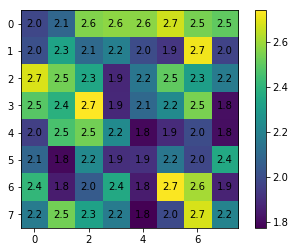

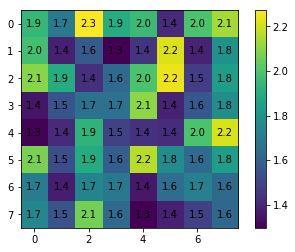

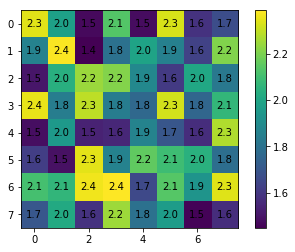

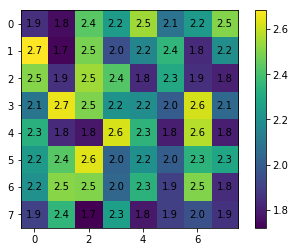

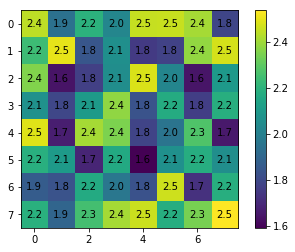

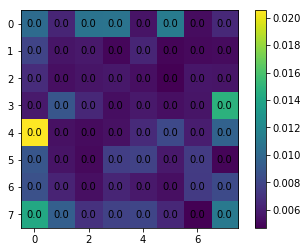

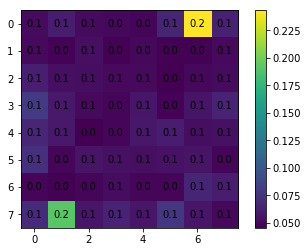

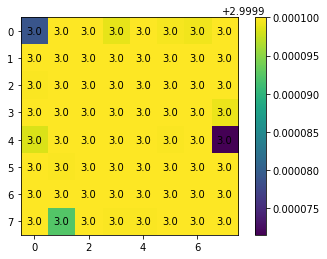

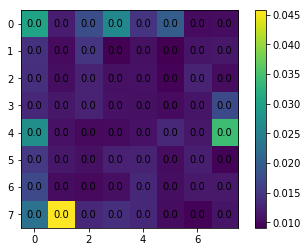

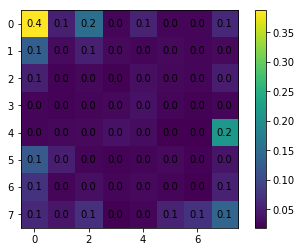

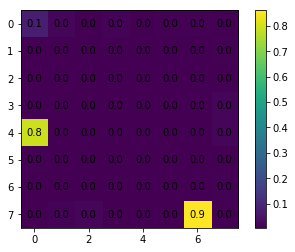

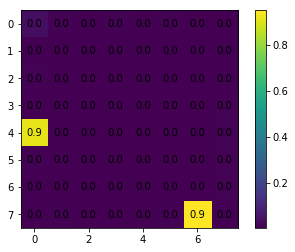

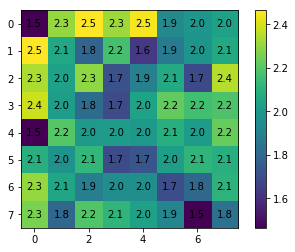

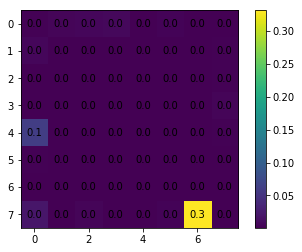

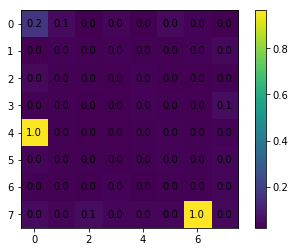

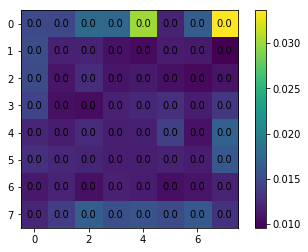

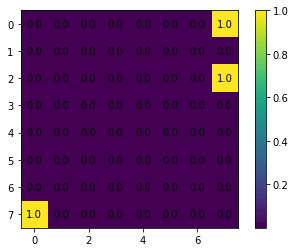

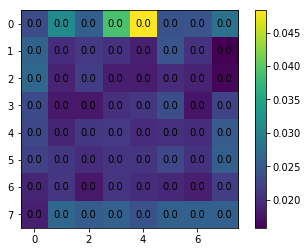

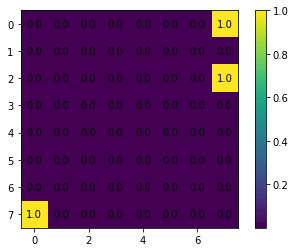

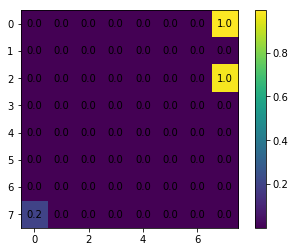

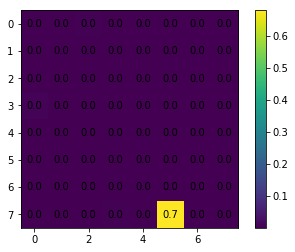

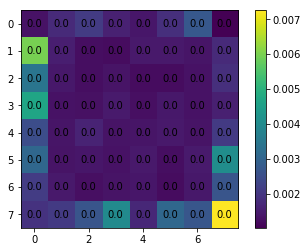

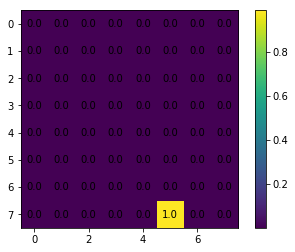

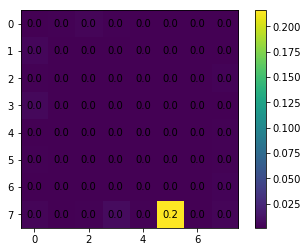

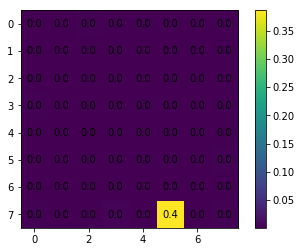

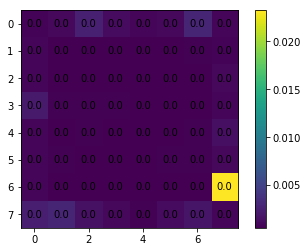

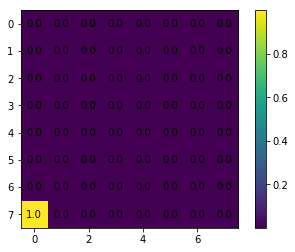

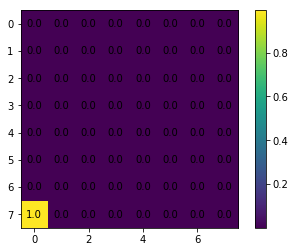

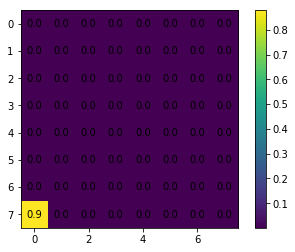

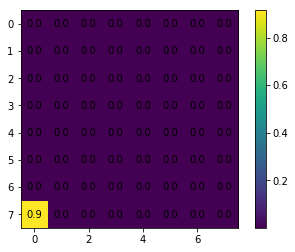

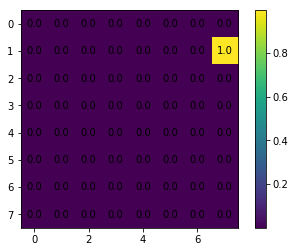

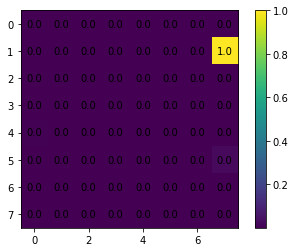

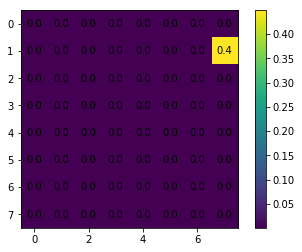

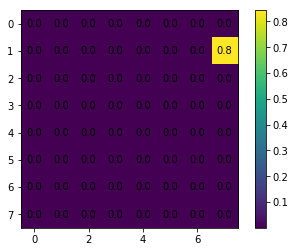

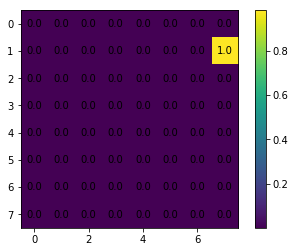

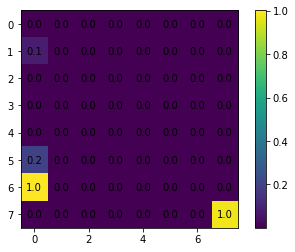

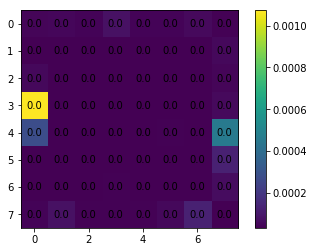

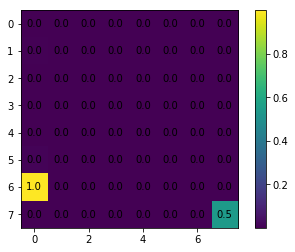

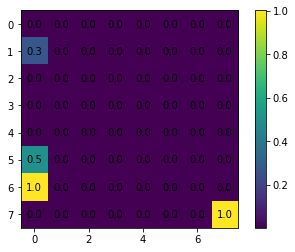

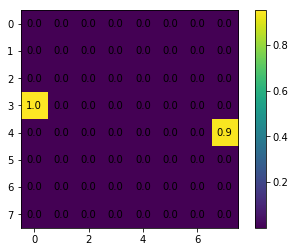

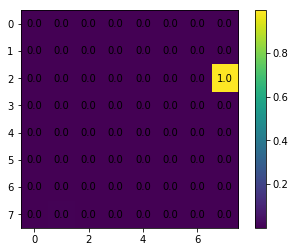

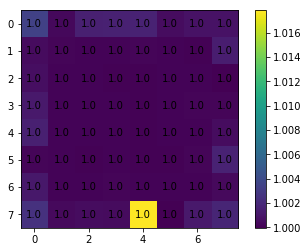

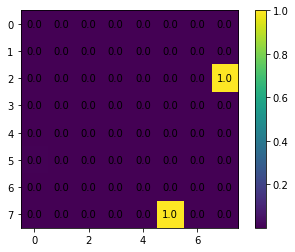

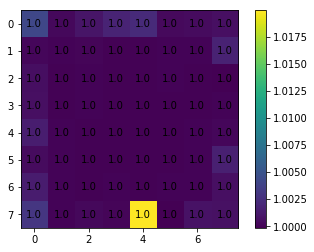

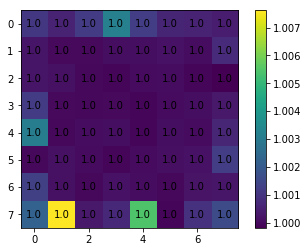

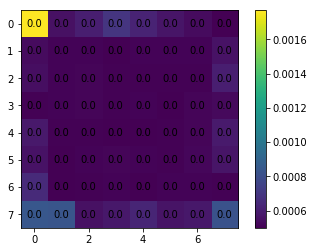

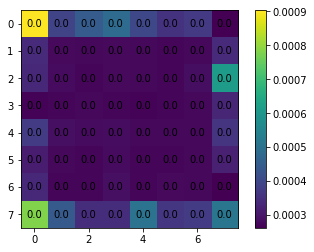

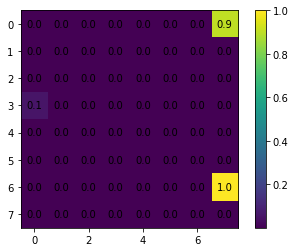

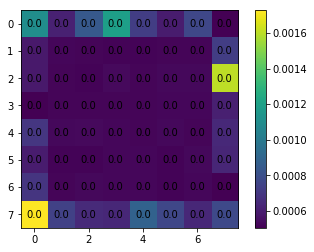

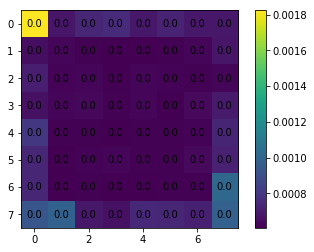

In [7]:
# Complex architecture
Dtest = gan.train(epochs=5000, batch_size=30, sample_interval=500)

# Generating

In [3]:
import h5py
from keras.models import load_model

In [4]:
generator = load_model('models/rewards/generator.h5')

/anaconda/envs/drl/lib/python2.7/site-packages/keras/engine/saving.py:270: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


In [5]:
OBSERVATION_SPACE = 64
ACTION_SPACE = 4
        
def to_onehot(size,value):
    my_onehot = np.zeros((size))
    my_onehot[value] = 1.0
    return my_onehot
    
def heatmap2d(hm_mat, title='', fig_num=1, text=True):
    plt.figure(fig_num)
    plt.imshow(hm_mat, interpolation='nearest')
    plt.title(title)
    plt.colorbar()
            
    if text:
        for y in range(hm_mat.shape[0]):
            for x in range(hm_mat.shape[1]):
                plt.text(x, y, '%.1f' % hm_mat[y, x],
                horizontalalignment='center',
                verticalalignment='center',
            )
            
def compute_reward(s,new_s,a,gen_imgs):
    zerostates = {12, 21, 29, 37, 44, 52, 58}
    s = to_onehot(OBSERVATION_SPACE,s)
    new_s = to_onehot(OBSERVATION_SPACE,new_s)
    a = to_onehot(ACTION_SPACE,a)
    vectorized = np.hstack((s,new_s,a))
    index = list(zerostates)
    vectorized = np.delete(vectorized, index)
    return np.dot(gen_imgs,vectorized)

def fill_rewards(gen_imgs):
    tofill = np.zeros((OBSERVATION_SPACE,OBSERVATION_SPACE,ACTION_SPACE)) 
    for s in xrange(0,OBSERVATION_SPACE):
        for new_s in xrange(0,OBSERVATION_SPACE):
            for a in xrange(0,ACTION_SPACE):
                tofill[(s,new_s,a)] = compute_reward(s,new_s,a,gen_imgs)
    sub = tofill[0, :, :]
    sub = np.max(sub,axis=1)
    return sub

In [6]:
def heatmap2d_vf(qtable,title,fig_num):
    heatmap2d(np.reshape(np.expand_dims(np.max(qtable,axis=1),1), (8, 8)), title=title, fig_num=fig_num, text=True)
    plt.savefig("experiments_rewards/%d.png" % fig_num, format='png')

In [17]:
pols[7], polsscratch[7]

(array([[u'<', u'>', u'v', u'v', u'v', u'v', u'<', u'v'],
        [u'v', u'<', u'>', u'v', u'v', u'v', u'v', u'v'],
        [u'v', u'v', u'<', u'v', u'>', u'v', u'v', u'v'],
        [u'v', u'v', u'v', u'v', u'<', u'v', u'v', u'v'],
        [u'>', u'>', u'>', u'>', u'>', u'>', u'v', u'v'],
        [u'v', u'v', u'v', u'v', u'v', u'<', u'>', u'v'],
        [u'>', u'>', u'>', u'>', u'>', u'>', u'>', u'^'],
        [u'>', u'>', u'^', u'<', u'>', u'>', u'>', u'^']], dtype='<U2'),
 array([[u'<', u'>', u'>', u'v', u'v', u'v', u'<', u'v'],
        [u'v', u'<', u'>', u'v', u'v', u'v', u'v', u'v'],
        [u'v', u'v', u'<', u'v', u'>', u'v', u'v', u'v'],
        [u'v', u'v', u'v', u'v', u'<', u'v', u'v', u'v'],
        [u'>', u'>', u'>', u'>', u'>', u'>', u'>', u'v'],
        [u'v', u'v', u'v', u'v', u'v', u'<', u'>', u'<'],
        [u'>', u'>', u'>', u'>', u'>', u'>', u'>', u'^'],
        [u'>', u'>', u'^', u'<', u'>', u'^', u'>', u'^']], dtype='<U2'))

Game #: 500
Moves this round 10
Final Position:
  (Left)
FFFFFSFF
FHHHFFFF
FFFFFHFF
HFFFFFHF
FFFFFFFF
FFFFFFFF
FFFFHFFF
FFFFFGFF
Wins/Losses 3/497


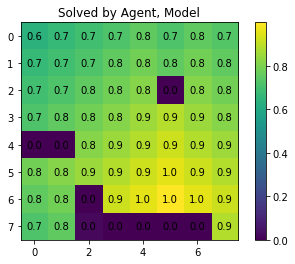

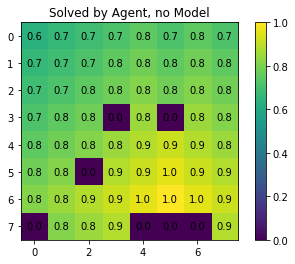

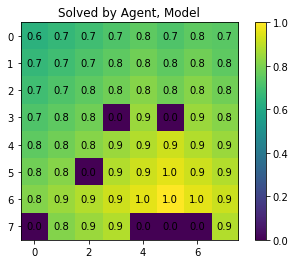

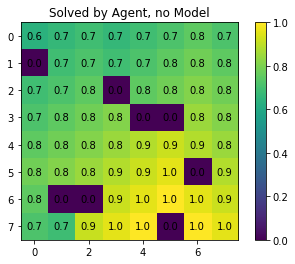

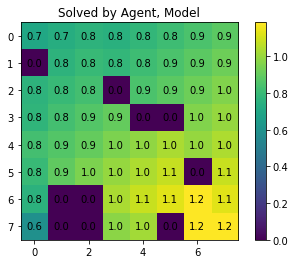

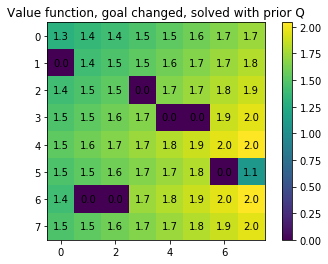

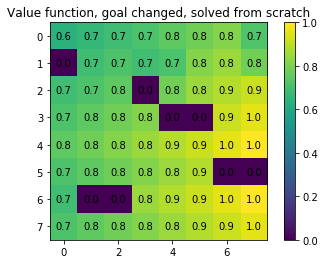

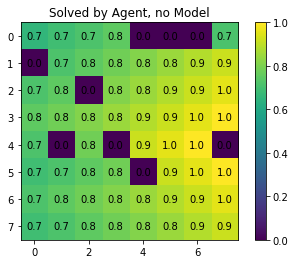

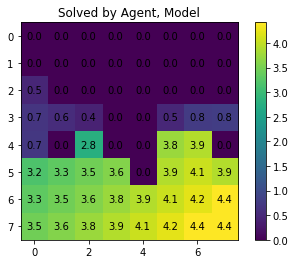

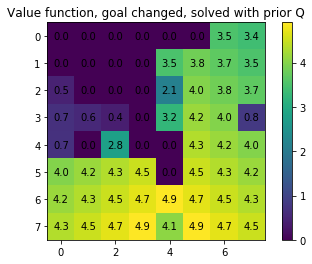

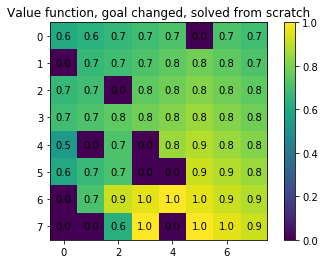

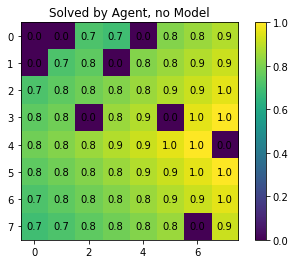

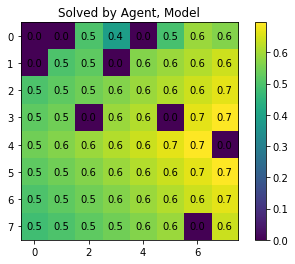

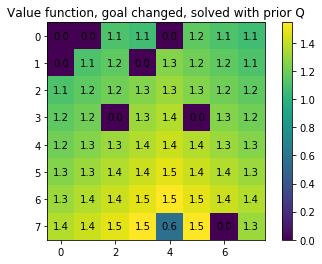

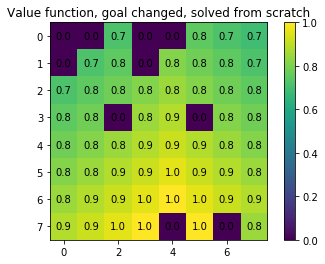

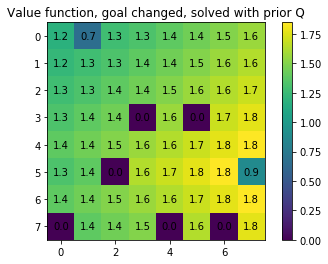

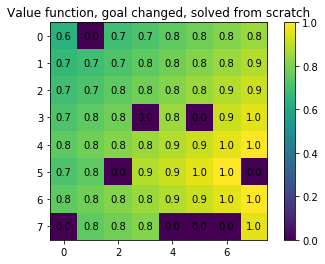

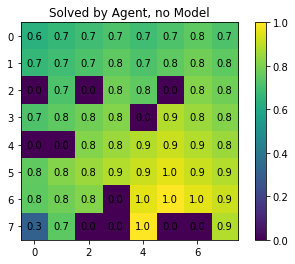

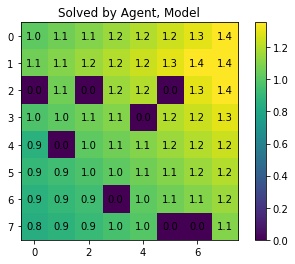

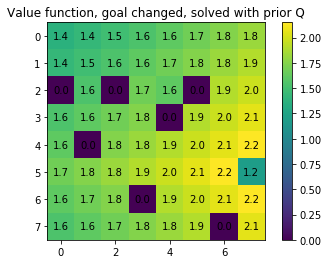

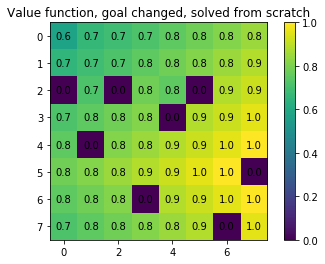

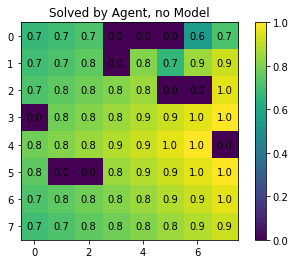

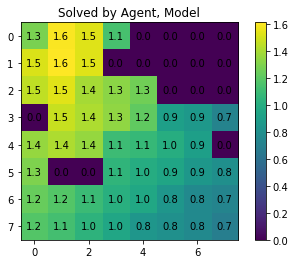

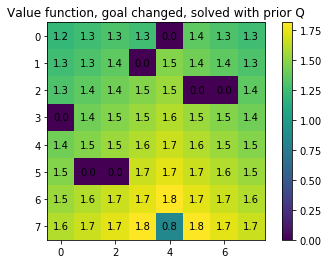

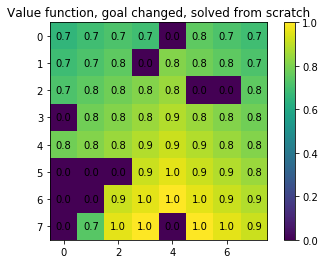

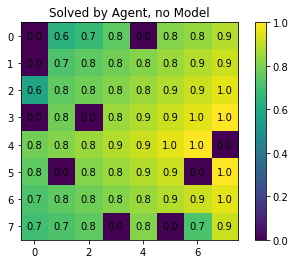

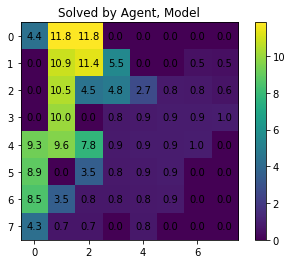

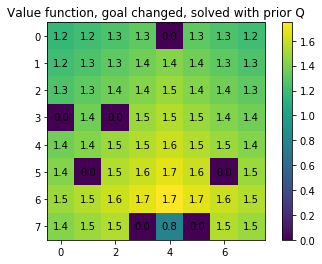

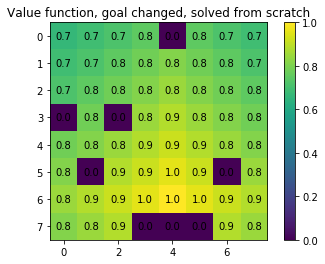

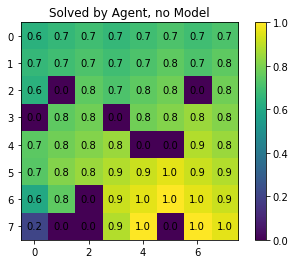

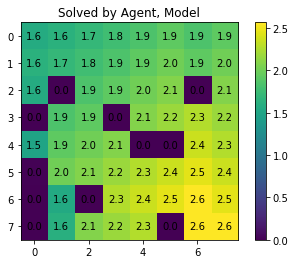

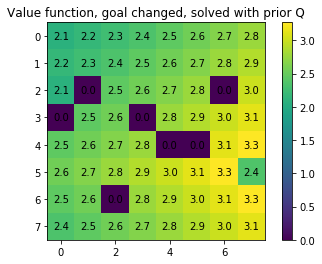

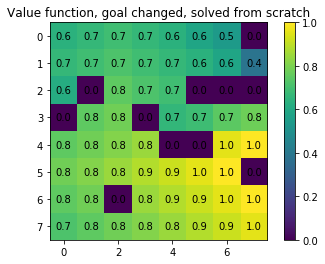

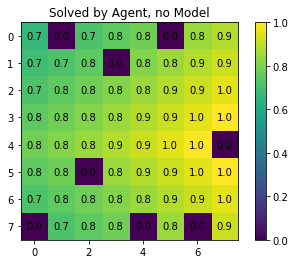

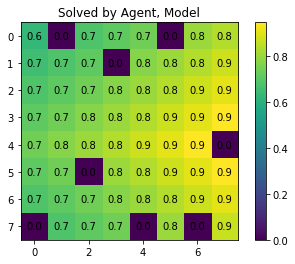

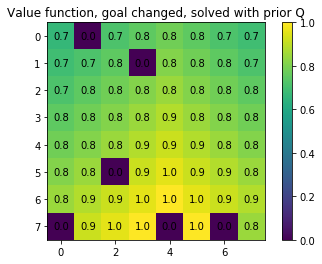

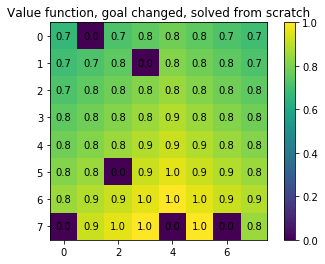

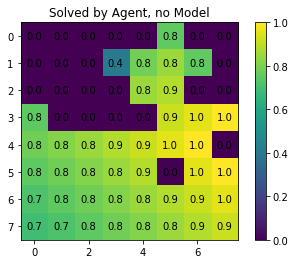

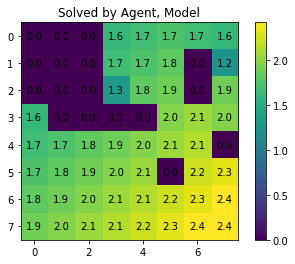

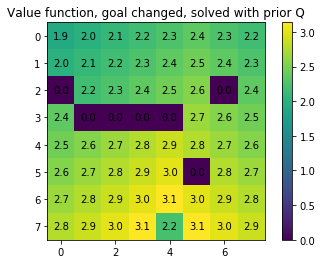

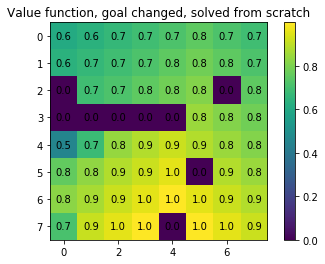

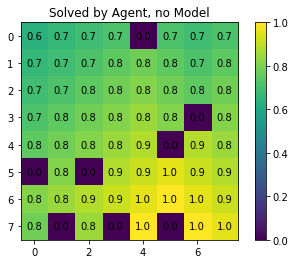

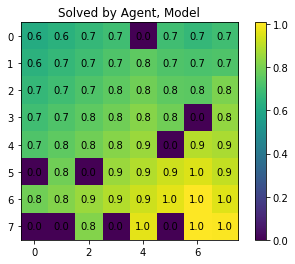

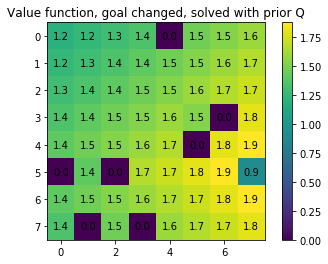

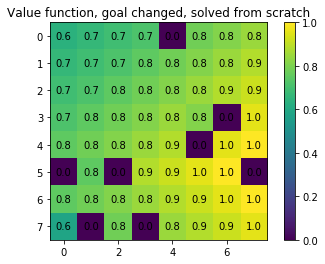

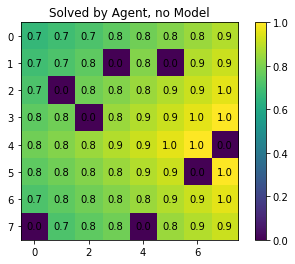

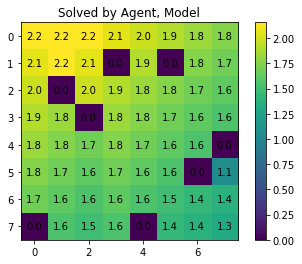

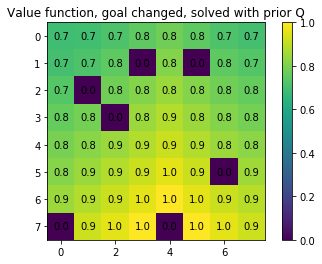

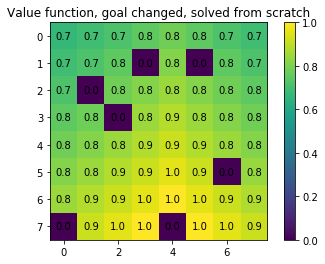

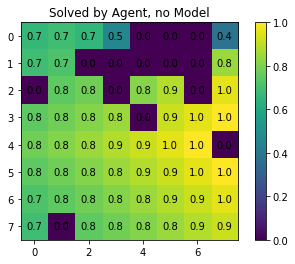

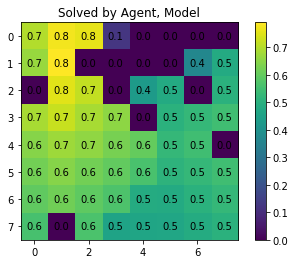

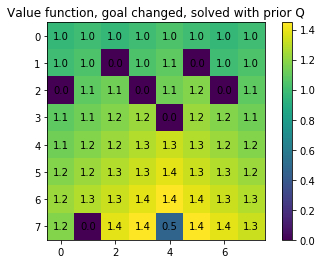

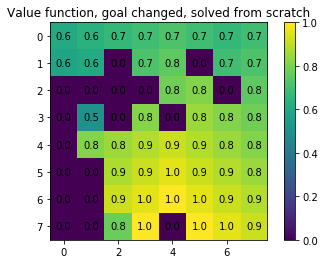

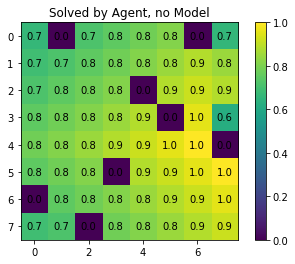

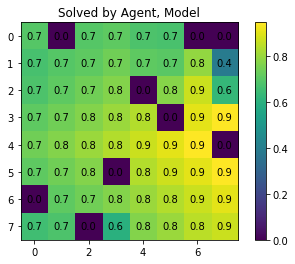

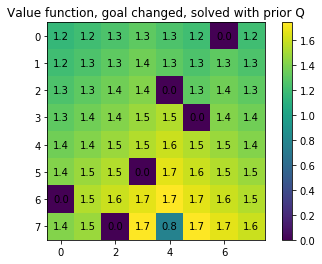

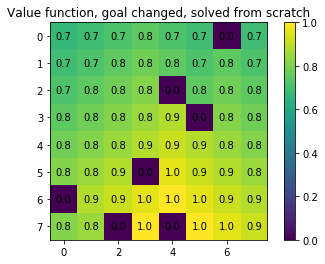

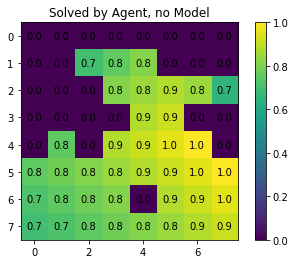

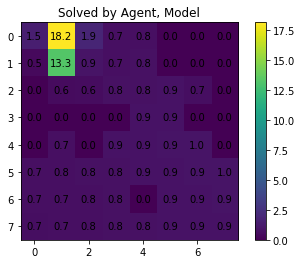

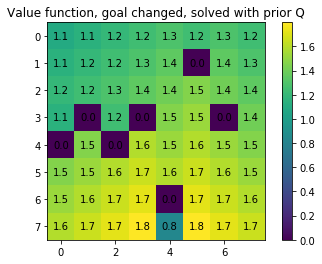

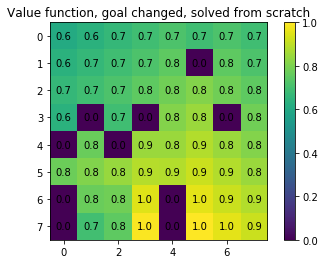

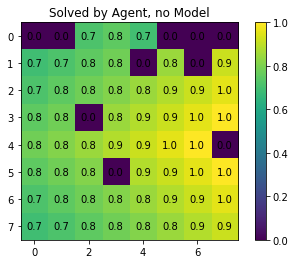

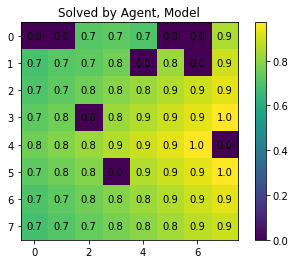

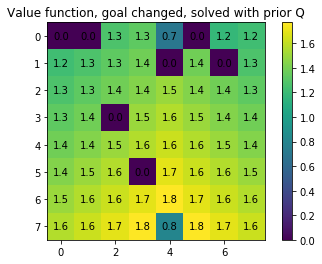

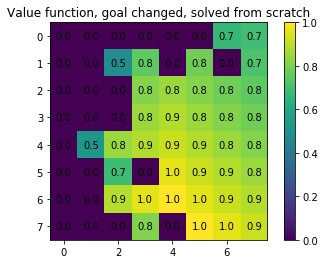

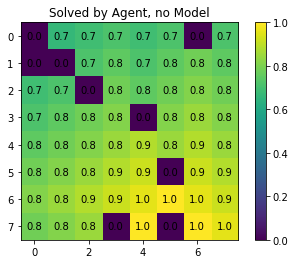

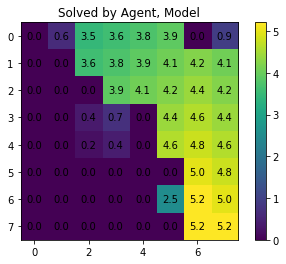

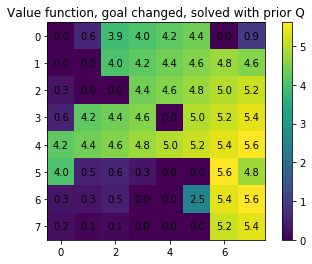

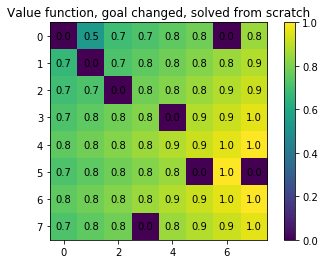

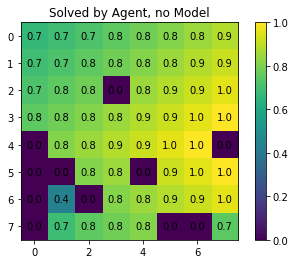

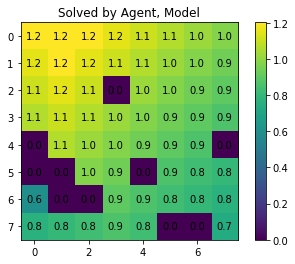

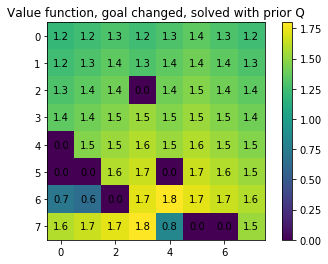

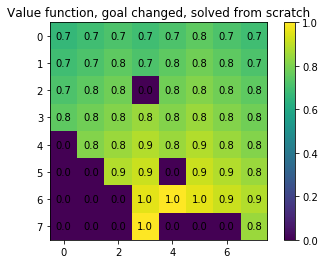

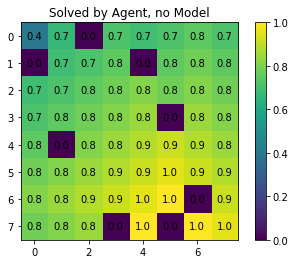

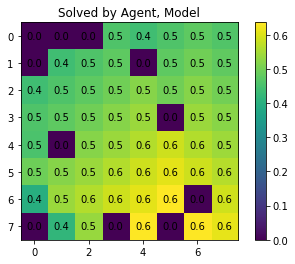

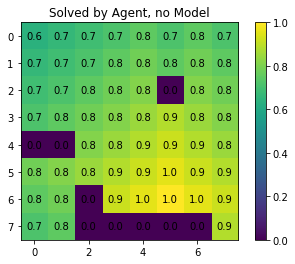

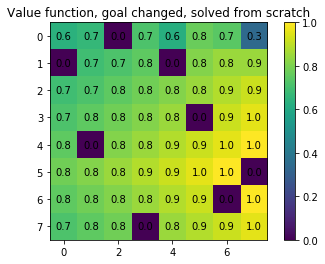

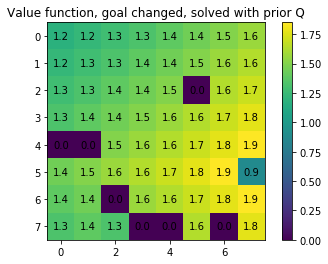

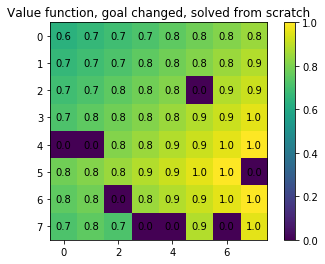

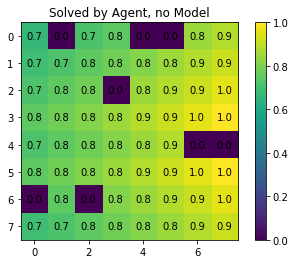

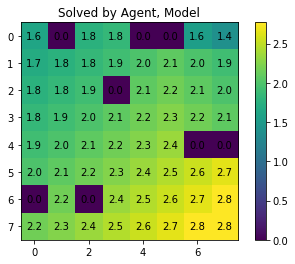

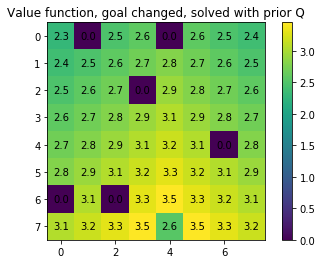

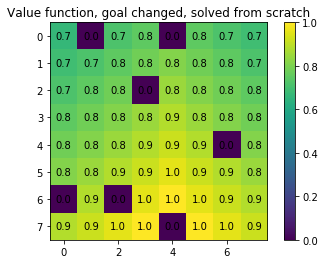

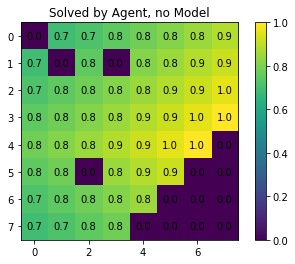

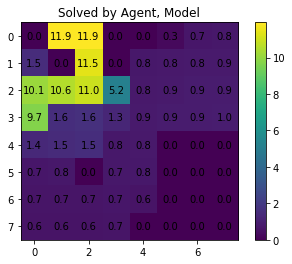

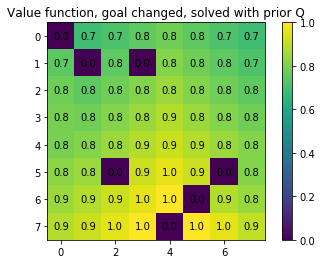

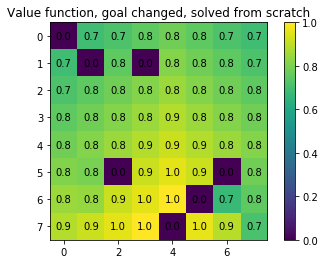

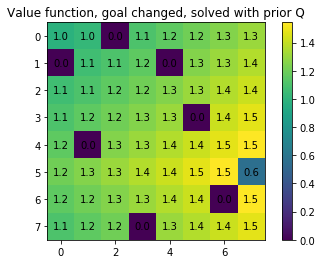

In [12]:
wp_per_game = list()
wpmodel_per_game = list()
wpmod_per_game = list()
wpscratch_per_game = list()

ti_per_game = list()
timodel_per_game = list()
timod_per_game = list()
tiscratch_per_game = list()

pols = list()
polsscratch = list()

allepochs=1000
target_iterations = 100
iteration = 0
while iteration < target_iterations:
#for iteration in range(5):

    noise = np.random.normal(0, 1, (1, 64))
    gen_imgs = generator.predict(noise)
    gen_imgs = np.squeeze(gen_imgs, axis=0)
    gen_imgs = np.squeeze(gen_imgs, axis=2)
    gen_imgs = np.squeeze(gen_imgs, axis=1)
    
    hm_mat = fill_rewards(gen_imgs)
    hm_mat = np.expand_dims(hm_mat,axis=1)
    
    a = np.reshape(hm_mat, (8, 8))
    
    if a.max() < 0.5 or a.max() > 2.0 or np.sum(a)>3.0:
        continue
    else:
        rowindex , colindex = numpy.unravel_index(a.argmax(), a.shape)
    
        name='FO8x8-v%d' % iteration
        env = make_environment(name,iteration,rowindex,colindex)

        namemod='FMx8-v%d' % iteration
        envmod = make_environment_modified(namemod,iteration,rowindex,colindex)
    
        q, wp, skip, ti = trainer(env,epochs=allepochs,use_model=False)
        if skip==True:
            del env, envmod
            iteration += 1
            continue
        qmodel, wpmodel, skip, timodel = trainer(env,epochs=allepochs,use_model=True)
        if skip==True:
            del env, envmod
            iteration += 1
            continue
        qmod, wpmod, skip, timod = trainer(envmod,epochs=allepochs,Q=qmodel.copy(),use_model=False)
        if skip==True:
            del env, envmod
            iteration += 1
            continue
        qscratch, wpscratch, skip, tiscratch = trainer(envmod,epochs=allepochs,use_model=False)
        if skip==True:
            del env, envmod
            iteration += 1
            continue
        
        wp_per_game.append(wp)
        ti_per_game.append(ti)
        
        wpmodel_per_game.append(wpmodel)
        timodel_per_game.append(timodel)
        
        wpmod_per_game.append(wpmod)
        timod_per_game.append(timod)
        
        wpscratch_per_game.append(wpscratch)
        tiscratch_per_game.append(tiscratch)
        
        pols.append(show_policy(envmod,qmod))
        polsscratch.append(show_policy(envmod,qscratch))
        
        heatmap2d_vf(q,'Solved by Agent, no Model',fig_num=int(str(iteration)+'1'))
        
        heatmap2d_vf(qmodel,'Solved by Agent, Model',fig_num=int(str(iteration)+'2'))
        
        heatmap2d_vf(qmod,'Value function, goal changed, solved with prior Q',fig_num=int(str(iteration)+'3'))
        
        heatmap2d_vf(qscratch,'Value function, goal changed, solved from scratch',fig_num=int(str(iteration)+'4'))
    
        del q, qmodel, qmod, qscratch, env, envmod
        
        iteration += 1
        
    print("Done")

In [13]:
wp_per_game, wpmodel_per_game, wpmod_per_game, wpscratch_per_game

([0.083,
  0.132,
  0.199,
  0.168,
  0.09,
  0.125,
  0.163,
  0.056,
  0.148,
  0.077,
  0.042,
  0.087,
  0.056,
  0.048,
  0.067,
  0.092,
  0.151,
  0.034,
  0.066,
  0.113,
  0.052,
  0.095],
 [0.077,
  0.026,
  0.141,
  0.13,
  0.101,
  0.145,
  0.173,
  0.009,
  0.084,
  0.093,
  0.046,
  0.047,
  0.014,
  0.091,
  0.062,
  0.025,
  0.062,
  0.035,
  0.087,
  0.055,
  0.058,
  0.01],
 [0.266,
  0.969,
  0.253,
  0.251,
  0.179,
  0.51,
  0.167,
  0.984,
  0.201,
  0.318,
  0.174,
  0.351,
  0.202,
  0.694,
  0.235,
  0.091,
  0.095,
  0.299,
  0.195,
  0.217,
  0.721,
  0.064],
 [0.046,
  0.124,
  0.132,
  0.07,
  0.204,
  0.033,
  0.052,
  0.078,
  0.025,
  0.095,
  0.038,
  0.097,
  0.073,
  0.089,
  0.046,
  0.067,
  0.054,
  0.078,
  0.04,
  0.098,
  0.115,
  0.038])

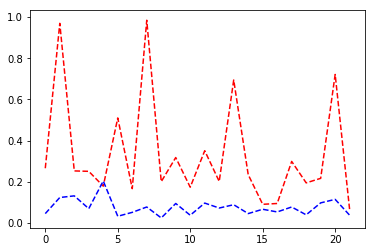

In [16]:
plt.plot(np.arange(0,22), np.array(wpmod_per_game), 'r--', np.arange(0,22), np.array(wpscratch_per_game), 'b--')

In [17]:
ti_per_game, timodel_per_game, timod_per_game, tiscratch_per_game

([36719,
  33469,
  47759,
  28669,
  26472,
  37216,
  41361,
  20732,
  39899,
  43967,
  49019,
  32793,
  17338,
  29020,
  36225,
  25573,
  29329,
  21584,
  24445,
  34738,
  20622,
  28954],
 [36722,
  86772,
  43889,
  24820,
  24673,
  68790,
  41055,
  80193,
  55002,
  48720,
  50620,
  49550,
  53026,
  45640,
  35463,
  54369,
  21207,
  16583,
  27419,
  28323,
  67630,
  82144],
 [48194,
  38992,
  43761,
  37838,
  48884,
  70407,
  24288,
  26302,
  63059,
  51459,
  35248,
  52746,
  63623,
  60116,
  57046,
  29048,
  25521,
  59539,
  45824,
  44864,
  61953,
  31897],
 [17932,
  29606,
  31128,
  20030,
  47121,
  25232,
  10308,
  32687,
  39048,
  31369,
  21085,
  28553,
  38568,
  22216,
  35586,
  16709,
  14762,
  44420,
  23237,
  34295,
  29259,
  20780])

In [7]:
def make_environment(name,seed,rowindex,colindex):
    register(
            id=name,
            entry_point='myfrozen.fl_custom:FrozenLakeEnv',
            kwargs={'map_name': '8x8', 'is_slippery': False,
            'seed': iteration, 'rowindex': rowindex, 'colindex': colindex},
            timestep_limit=100,
            reward_threshold=0.78,
            )
    env = gym.make(name)
    return env

def make_environment_modified(name,seed,rowindex,colindex):
    register(
            id=name,
            entry_point='myfrozen.fl_custom:FrozenLakeEnv',
            kwargs={'map_name': '8x8', 'is_slippery': False,
            'seed': iteration, 'rowindex': colindex, 'colindex': rowindex},
            timestep_limit=100,
            reward_threshold=0.78,
            )
    env = gym.make(name)
    return env

In [8]:
def eps_greedy(curr_s, q_value, epsilon=0.1):
    a = np.argmax(q_value[curr_s, :])
    if np.random.rand() < epsilon:
        a = np.random.randint(q_value.shape[1])
    return a

In [9]:
def run_episode(env,Q,learning_rate,gamma,episode,max_steps,use_model=True):
    observation = env.reset()
    done = False
    t_reward = 0
    #max_steps = 60
    move_counter = 0
    for j in range(max_steps):
        if done:
            break

        curr_state = observation

        action = np.argmax(Q[curr_state,:]  + np.random.randn(1, env.action_space.n))
        #action = eps_greedy(curr_state, Q, epsilon=.5)
        
        move_counter+=1
        
        observation, true_reward, done, info = env.step(action)
        #true_reward = deepcopy(reward)
        
        if use_model:
            reward = compute_reward(curr_state,observation,action,gen_imgs)
        else:
            reward = deepcopy(true_reward)
            
        t_reward += reward

        Q[curr_state,action] += learning_rate * (reward+ gamma*np.max(Q[observation,:])-Q[curr_state,action])

    return Q, t_reward, done, move_counter, true_reward

In [10]:
def trainer(env,epochs=1000,learning_rate = 0.81,discount = 0.96, use_model=False, **kwargs):
    
    #reward_per_ep = list()
    wins = 0
    losses = 0
    max_steps = 100
    wins_threshold = 5
    skip = False
    t_interactions = 0
    
    if not 'Q' in kwargs:
        Q = np.zeros((env.observation_space.n, env.action_space.n))
        #Q = np.random.rand(env.observation_space.n, env.action_space.n)
    else:
        Q = kwargs.get('Q', None)
    
    for i in range(epochs):

        Q, t_reward, done, move_counter, true_reward = run_episode(env,Q,learning_rate,discount,i,
                                                                   max_steps=max_steps,use_model=use_model)
        
        t_interactions += move_counter
        #reward_per_ep.append(t_reward)

        if done:
            if true_reward > 0 : # Win
                wins += 1
            else: # Loss
                losses += 1
        else:
            if move_counter==max_steps:
                losses += 1
        
        if i == 500 and wins < wins_threshold:
            skip = True
            break
        
        #time.sleep(.1)        
        clear_output(wait=True)
        print("Game #: %s" % (i+1,))
        print("Moves this round %s" % move_counter)
        print("Final Position:")
        env.render()
        print("Wins/Losses %s/%s" % (wins, losses))
    winpercent = float(wins/epochs)
    return Q, winpercent, skip, t_interactions

# A TEST

In [11]:
def show_policy(env,Q):
    A2A=['<','v','>','^']
    
    OBSERVATION_SPACE = env.observation_space.n
    ACTION_SPACE = env.action_space.n
    OBS_SQR = int(math.sqrt(OBSERVATION_SPACE))
    STATEGRID = np.zeros((OBS_SQR,OBS_SQR))
    
    grid = np.zeros((OBS_SQR,OBS_SQR), dtype='<U2')

    obs_sqr = math.sqrt(OBSERVATION_SPACE)

    working_state = STATEGRID.copy()
    
    for x in range(0,OBS_SQR):
        for y in range(0,OBS_SQR):
            my_state = working_state.copy()
            my_state[x,y] = 1

            obs_predict = my_state.reshape(1,OBSERVATION_SPACE,)
            obs_predict = np.squeeze(obs_predict)
            index, = np.where(obs_predict == 1.)
            action = np.argmax(Q[index,:])
            grid[x,y] = A2A[action]
    return grid

In [35]:
show_policy(env,q)

array([[u'v', u'v', u'<', u'v', u'v', u'v', u'v', u'<'],
       [u'v', u'v', u'<', u'>', u'v', u'v', u'v', u'<'],
       [u'v', u'v', u'<', u'<', u'v', u'>', u'v', u'<'],
       [u'v', u'v', u'<', u'v', u'<', u'<', u'v', u'<'],
       [u'v', u'v', u'v', u'v', u'<', u'v', u'<', u'<'],
       [u'>', u'>', u'v', u'v', u'v', u'v', u'<', u'<'],
       [u'<', u'<', u'v', u'v', u'v', u'v', u'<', u'v'],
       [u'>', u'>', u'>', u'>', u'>', u'<', u'<', u'<']], dtype='<U2')

In [36]:
show_policy(envmod,qmod)

array([[u'v', u'v', u'v', u'v', u'v', u'v', u'v', u'v'],
       [u'v', u'v', u'>', u'>', u'v', u'v', u'v', u'v'],
       [u'v', u'v', u'<', u'<', u'>', u'>', u'v', u'v'],
       [u'v', u'v', u'<', u'v', u'<', u'<', u'v', u'v'],
       [u'v', u'v', u'v', u'v', u'<', u'v', u'v', u'v'],
       [u'>', u'>', u'>', u'>', u'>', u'>', u'>', u'<'],
       [u'<', u'<', u'>', u'>', u'>', u'^', u'<', u'^'],
       [u'>', u'>', u'>', u'>', u'>', u'^', u'<', u'^']], dtype='<U2')

In [37]:
show_policy(envmod,qscratch)

array([[u'v', u'v', u'v', u'v', u'v', u'v', u'v', u'v'],
       [u'>', u'>', u'>', u'>', u'v', u'v', u'v', u'v'],
       [u'v', u'v', u'^', u'<', u'>', u'>', u'v', u'v'],
       [u'v', u'v', u'<', u'v', u'^', u'<', u'v', u'v'],
       [u'>', u'>', u'v', u'v', u'<', u'>', u'>', u'v'],
       [u'>', u'>', u'>', u'>', u'>', u'>', u'>', u'<'],
       [u'<', u'<', u'>', u'>', u'>', u'^', u'<', u'^'],
       [u'>', u'>', u'^', u'>', u'>', u'^', u'>', u'^']], dtype='<U2')

In [33]:
env.render()

  (Right)
FFSFFFFF
FFFFFFFF
FFFHFFFF
FFHFFHFF
FFFFHFFF
FFFFFFFF
HHFFFFHF
FFFFFGFF


In [34]:
envmod.render()

  (Down)
FFFFFFFF
FFFFFFFF
SFFHFFFF
FFHFFHFF
FFFFHFFF
FFFFFFFG
HHFFFFHF
FFFFFFFF


In [38]:
show_policy(envmod,qmod)

array([[u'v', u'v', u'v', u'v', u'v', u'v', u'v', u'v'],
       [u'v', u'v', u'>', u'>', u'v', u'v', u'v', u'v'],
       [u'v', u'v', u'<', u'<', u'>', u'>', u'v', u'v'],
       [u'v', u'v', u'<', u'v', u'<', u'<', u'v', u'v'],
       [u'v', u'v', u'v', u'v', u'<', u'v', u'v', u'v'],
       [u'>', u'>', u'>', u'>', u'>', u'>', u'>', u'<'],
       [u'<', u'<', u'>', u'>', u'>', u'^', u'<', u'^'],
       [u'>', u'>', u'>', u'>', u'>', u'^', u'<', u'^']], dtype='<U2')